# INFO2950 Final Project Phase IV

#### By Julianna Castlegrant (jgc254), Jillian Creighton (jcc429), and Matthew Roohan (mlr287)

In [348]:
## this code cell is also marked as 'narrative'
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

import duckdb, sqlalchemy

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.dummy import DummyClassifier

In [337]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

# Introduction

We are using data collected from the Guiding Eyes for the Blind Organization to try and answer the research question: What factors impact the ability to pass the final guide dog exam? Factors of particular interest include dam and sire, so we ran two hypothesis tests to determine if these two variables separately have an influence on the probability of a pup passing their final exam. Our main findings found that who a pup’s dam and sire does matter, and that having a certain dam or sire can influence one’s likelihood of passing the final exam. The results of our analysis are important because they can be used by the organization to determine how they go forward with breeding and training successful guide dogs. Our results can be taken into account by the organization to determine which pups may need special attention to ensure higher probabilities of success. However, the degree of confidence for which we should view these results is up for debate due to limitations. This will all be explored in-depth below.

# Data Description

**Note:** Since our data collection and cleaning was on the longer side, we were advised by Professor Mimno to keep it as a separate jupyter notebook, which can be viewed here: https://github.com/Julianna-Castlegrant/info2950-group-proj/blob/main/finalproject/.ipynb_checkpoints/datacollectionandcleaning-checkpoint.ipynb.

We describe our data thoroughly while doing our data cleaning process (because part of being able to correctly clean data involves explaining and understanding the context behind that data), which can be viewed by clicking the link above. So we recommend reading through that notebook, particularly the sections relevent to the creation of `new_dog_data.csv` and `new_predict_dog_data.csv`.

However, in order to get an even better understanding of our data, we answered the following questions presented in Gebru et al. 'Datasheets for Dataset' (link: https://arxiv.org/abs/1803.09010). Our answers will give a better sense of what our data entails.

## 3.1 Motivation

- For what purpose was the dataset created? Was there a specific task in mind? Was there a specific gap that needed to be filled? Please provide a description.
> This dataset was created to keep track of the status of and all important information regarding dogs who are a part of the Guiding Eyes for the Blind program during 2015 and after. 
- Who created the dataset (e.g., which team, research group) and on behalf of which entity (e.g., company, institution, organization)?
> The organization itself (particularly the Canine Program Development department) created the original dataset on behalf of themselves. Our group then created our own dataset based on data obtained from the original dataset.
- Who funded the creation of the dataset? If there is an associated grant, please provide the name of the grantor and the grant name and number.
> N/A
- Any other comments?
> N/A

## 3.2 Composition

- What do the instances that comprise the dataset represent (e.g., documents, photos, people, countries)? Are there multiple types of instances (e.g., movies, users, and ratings; people and interactions be- tween them; nodes and edges)? Please provide a description.
> The instances represent the dogs within the organization during 2020 and after. There are not multiple types of each instance, each instance is a dog. For each dog, we are told traits about it like name, breed, color, region, gender, birthdate, current status date, sire, dam, tattoo (unique identifier), status, etc. This is true of both datasets (because we split the original dataset into dogs we know have passed or failed and dogs we can predict).
- How many instances are there in total (of each type, if appropri- ate)?
> clean_dog_data.csv has 474 instances and predict_dog_data has 638 instances.
- Does the dataset contain all possible instances or is it a sample (not necessarily random) of instances from a larger set? If the dataset is a sample, then what is the larger set? Is the sample representa- tive of the larger set (e.g., geographic coverage)? If so, please describe how this representativeness was validated/verified. If it is not representative of the larger set, please describe why not (e.g., to cover a more diverse range of instances, because instances were withheld or unavailable).
> Yes, the dataset is all the dogs since 2020.
- What data does each instance consist of? “Raw” data (e.g., unpro- cessed text or images) or features? In either case, please provide a description.
> Raw data because the columns are unprocessed text describing the traits of the dog, such as its dam, sire, birthdate, breed, etc.
- Is there a label or target associated with each instance? If so, please provide a description.
> No
- Is any information missing from individual instances? If so, please provide a description, explaining why this information is missing (e.g., because it was unavailable). This does not include intentionally removed information, but might include, e.g., redacted text.
> Some of the regions for individual dogs was missing because it was not available. The organization removed that information from the set over time depending on that dogs change in status.
- Are relationships between individual instances made explicit (e.g., users’ movie ratings, social network links)? If so, please describe how these relationships are made explicit.
> N/A
- Are there recommended data splits (e.g., training, development/validation, testing)? If so, please provide a description of these splits, explaining the rationale behind them.
> Yes. alldogsreport-oldestyears.csv can be split into training data, which are the dogs for which we know passed or failed (we made this into new_dog_data.csv) and the testing data, which are dogs for which we want to test to see if we can predict whether they will pass or fail depending on training data (we made this into new_predict_dog_data.csv).
- Are there any errors, sources of noise, or redundancies in the dataset? If so, please provide a description.
> The errors we encountered were that some of the dogs had an a graduation date but were not listed with the status "Graduated" due to various context-based reasons (which we explained each one in depth during data cleaning like with Jason). We fixed this on the dataset by using the .loc[] function to change the value of these cells to a better-fitting value. Moreover, another issue was that there were dogs that were retired but did not have a graduation date inputted (despite the fact that most dogs with the status Retired do have a graduation date), so we exlcluded those from our dataset because they would not contribute to our analysis and would only cause further confusion down the line.
- Is the dataset self-contained, or does it link to or otherwise rely on external resources (e.g., websites, tweets, other datasets)? If it links to or relies on external resources, a) are there guarantees that they will exist, and remain constant, over time; b) are there official archival versions of the complete dataset (i.e., including the external resources as they existed at the time the dataset was created); c) are there any restrictions (e.g., licenses, fees) associated with any of the external resources that might apply to a dataset consumer? Please provide descriptions of all external resources and any restrictions associated with them, as well as links or other access points, as appropriate.
> Self-contained
- Does the dataset contain data that might be considered confidential (e.g., data that is protected by legal privilege or by doctor– patient confidentiality, data that includes the content of individuals’ non-public communications)? If so, please provide a description.
> No
- Does the dataset contain data that, if viewed directly, might be offensive, insulting, threatening, or might otherwise cause anxiety? If so, please describe why. If the dataset does not relate to people, you may skip the remaining questions in this section. 
> No
- Does the dataset identify any subpopulations (e.g., by age, gender)? If so, please describe how these subpopulations are identified and provide a description of their respective distributions within the dataset. 
> Yes, the dataset identifies the dogs as either male or female.
- Is it possible to identify individuals (i.e., one or more natural persons), either directly or indirectly (i.e., in combination with other data) from the dataset? If so, please describe how. 
> No
- Does the dataset contain data that might be considered sensitive in any way (e.g., data that reveals race or ethnic origins, sexual orientations, religious beliefs, political opinions or union memberships, or locations; financial or health data; biometric or genetic data; forms of government identification, such as social security numbers; criminal history)? If so, please provide a description. 
> No 
- Any other comments?
> N/A

## 3.3 Collection Process

- How was the data associated with each instance acquired? Was the data directly observable (e.g., raw text, movie ratings), reported by subjects (e.g., survey responses), or indirectly inferred/derived from other data (e.g., part-of-speech tags, model-based guesses for age or language)? If the data was reported by subjects or indirectly inferred/derived from other data, was the data validated/verified? If so, please describe how.
> The data was inputted by the company based on whether a dog passed or failed their final test.
- What mechanisms or procedures were used to collect the data (e.g., hardware apparatuses or sensors, manual human curation, software programs, software APIs)? How were these mechanisms or procedures validated?
> Manual human curation. Someone within the organization manually inputted the data about each dog and their status.
- If the dataset is a sample from a larger set, what was the sampling strategy (e.g., deterministic, probabilistic with specific sampling probabilities)?
> N/A
- Who was involved in the data collection process (e.g., students, crowdworkers, contractors) and how were they compensated (e.g., how much were crowdworkers paid)?
> Employees of the Guiding Eyes for the Blind organization.
- Over what timeframe was the data collected? Does this timeframe match the creation timeframe of the data associated with the instances (e.g., recent crawl of old news articles)? If not, please describe the time- frame in which the data associated with the instances was created.
> The time frame was dogs born after January 2015.
- Were any ethical review processes conducted (e.g., by an institu- tional review board)? If so, please provide a description of these review processes, including the outcomes, as well as a link or other access point to any supporting documentation.
> N/A

## 3.4 Preprocessing/cleaning/labeling

- Was any preprocessing/cleaning/labeling of the data done (e.g., discretization or bucketing, tokenization, part-of-speech tagging, SIFT feature extraction, removal of instances, processing of missing values)? If so, please provide a description. If not, you may skip the remaining questions in this section.
> Yes, as explained in the "Cleaning" Section. Go to the "Data Cleaning Description" appendix, click that link and it will display our data cleaning process in its entirety.
- Was the “raw” data saved in addition to the preprocessed/cleaned/labeled data (e.g., to support unanticipated future uses)? If so, please provide a link or other access point to the “raw” data.
> The "raw" data can be found in the csv file titled alldogsreport-oldestyears.csv, which can be accessed by going to the Source Code section, clicking the provided link that takes you to our public GitHub page for this project, and then clicking the csv file with said title.
- Is the software that was used to preprocess/clean/label the data available? If so, please provide a link or other access point.
> N/A
- Any other comments?
> N/A

## 3.5 Uses

- Has the dataset been used for any tasks already? If so, please provide a description.
> No
- Is there a repository that links to any or all papers or systems that use the dataset? If so, please provide a link or other access point.
> N/A
- What (other) tasks could the dataset be used for?
> The dataset could be used to track each dog, make organizational decisions about training methods, and financial decisions on whether the program structure is optimal. 
- Is there anything about the composition of the dataset or the way it was collected and preprocessed/cleaned/labeled that might im- pact future uses? For example, is there anything that a dataset consumer might need to know to avoid uses that could result in unfair treatment of individuals or groups (e.g., stereotyping, quality of service issues) or other risks or harms (e.g., legal risks, financial harms)? If so, please provide a description. Is there anything a dataset consumer could do to mitigate these risks or harms?
> No
- Are there tasks for which the dataset should not be used? If so, please provide a description.
> No
- Any other comments?
> N/A

# Preregistration Statement

Hypothesis 1 (Dam and Pass_Fail):
- Null Hypothesis: Who the dam (mother) is does not impact the probability of passing the final exam [so all $𝜷_{dam_i} = 0$ where variable i denotes the name of some dam since we do not know which exact dam may have a significant impact)].
- Alternative Hypothesis: Who the dam is significantly impacts the probability of passing the final exam, either negatively or positively [at least one dam so $𝜷_{dam_i} > 0$ and/or  $𝜷_{dam_i} < 0$ (> 0 means that this dam will increase the probability of passing, and < 0 means this dam will decrease the probability)].

Hypothesis 2 (Sire and Pass_Fail):
- Null Hypothesis: Who the sire (father) is does not impact the probability of passing the final exam [so all $𝜷_{sire_i} = 0$ where variable i denotes the name of some sire since we do not know which exact sire may have a significant impact)].
- Alternative Hypothesis: Who the sire is significantly impacts the probability of passing the final exam, either negatively or positively [at least one sire so $𝜷_{sire_i} > 0$ and/or  $𝜷_{sire_i} < 0$].

We predict that we will reject the null hypothesis for both hypotheses.

# Data Analysis

In order to analyze our data, we must first load in the necessary csv files, as shown below.

In [484]:
clean_new_dogs_df = pd.read_csv('new_dog_data.csv')
clean_new_dogs_df = clean_new_dogs_df.drop(columns = ['Unnamed: 0'])
clean_new_dogs_df['Birthdate'] = pd.to_datetime(clean_new_dogs_df['Birthdate'])
clean_new_dogs_df['Current Status Date'] = pd.to_datetime(clean_new_dogs_df['Current Status Date'])
clean_new_dogs_df.head()

Dog Name  Tattoo  Gender Breed Color  Birthdate  \
0        Almond   1A322  Female    LR     Y 2022-08-26   
1       William  10WW22    Male    LR     Y 2022-08-20   
2          Wind   4WW22  Female    LR     B 2022-08-20   
3        Whispy   2WW22  Female    LR     Y 2022-08-20   
4  Vega (Tilly)   2VV22  Female    LR     Y 2022-08-06   

                         Dam                    Sire Current Status Date  \
0        Demi - 5D319 - LRYF     Clay - 5C319 - LRYM          2022-10-19   
1        Liza - 5L318 - LRBF  Everett - 1E419 - LRYM          2022-10-21   
2        Liza - 5L318 - LRBF  Everett - 1E419 - LRYM          2022-10-21   
3        Liza - 5L318 - LRBF  Everett - 1E419 - LRYM          2022-10-21   
4  Bianca - P - 5B317 - LRYF     Clay - 5C319 - LRYM          2022-09-30   

         Status  Pass_Fail  
0      Released      False  
1      Released      False  
2  Other School       True  
3  Other School       True  
4      Released      False

In [477]:
new_dogs_to_predict_df = pd.read_csv('new_predict_dog_data.csv')
new_dogs_to_predict_df = new_dogs_to_predict_df.drop(columns = ['Unnamed: 0'])
new_dogs_to_predict_df.head()

Dog Name Tattoo  Gender Breed Color   Birthdate                    Dam  \
0     Pearl  7P322  Female    LR     Y  2022-10-31  Orchid - 6O417 - LRYF   
1   Paisley  3P322  Female    LR     B  2022-10-31  Orchid - 6O417 - LRYF   
2   Prairie  1P322  Female    LR     B  2022-10-31  Orchid - 6O417 - LRYF   
3  Pembroke  5P322    Male    LR     Y  2022-10-31  Orchid - 6O417 - LRYF   
4     Petal  2P322  Female    LR     B  2022-10-31  Orchid - 6O417 - LRYF   

                   Sire Current Status Date             Status  
0  Elton - 4EE20 - LRBM          2022-10-31  Too Young to Test  
1  Elton - 4EE20 - LRBM          2022-10-31  Too Young to Test  
2  Elton - 4EE20 - LRBM          2022-10-31  Too Young to Test  
3  Elton - 4EE20 - LRBM          2022-10-31  Too Young to Test  
4  Elton - 4EE20 - LRBM          2022-10-31  Too Young to Test

## Describing the Data

Because each column of our dataframe is a categorical variable, we will use descriptive statistics such as counts and frequencies to summarize our data. We will also use count plots, mosaic plots, and bar plots to visually display the data.

Since two of our columns  - "Current Status Date" and "Birthdate" - are more unique because they are datetime objects, we can start with them.

### Current Status Date

Current Status Date is the date that the dog's status was last updated, which can help show pass/fail rates throughout each year because a status date will change right when the status changes, which usually happens when changing a dog's status from one of a passing dog to one of a failing dog. Therefore, we can groupby this column to see about how many dogs have passed per year in 2020 and after, which is show below.

In [485]:
current_status_df = clean_new_dogs_df[['Current Status Date', 'Pass_Fail']].groupby(clean_new_dogs_df['Current Status Date'].dt.year).sum()
current_status_df

Pass_Fail
Current Status Date           
2015                       101
2016                       200
2017                       178
2018                       136
2019                       196
2020                       188
2021                       203
2022                       248

The mean, standard deviation, and variance of these pass counts are shown below.

In [486]:
current_status_df['Pass_Fail'].mean()

181.25

In [487]:
current_status_df['Pass_Fail'].std()

44.78759394551767

In [488]:
current_status_df['Pass_Fail'].var()

2005.9285714285713

From this table, we can see that noticeably fewer dogs passed in 2020 (188 dogs) compared to 2021 and 2022. 2022 has the most dogs who have passed per year (248 dogs), despite the fact that the year is not even over yet. 2015 has the lowest number of dogs who have passed per year (101 dogs).

We can display the distribution of how many dogs pass per year via a lineplot. Said lineplot is shown below.

<function matplotlib.pyplot.show(close=None, block=None)>

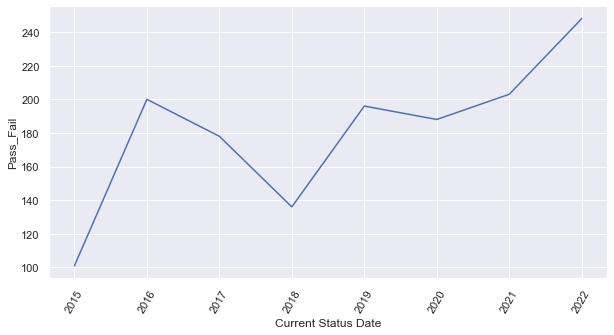

In [353]:
sns.lineplot(data=current_status_df, x='Current Status Date', y='Pass_Fail')
plt.xticks(rotation = 60)
sns.set(rc={"figure.figsize":(10, 5)})
plt.show

We can break this data down farther to see a distribution of how many dogs are passing per month per year via a lineplot.

The lineplot right below shows the distribution of how many dogs pass per month in the year 2020.

<function matplotlib.pyplot.show(close=None, block=None)>

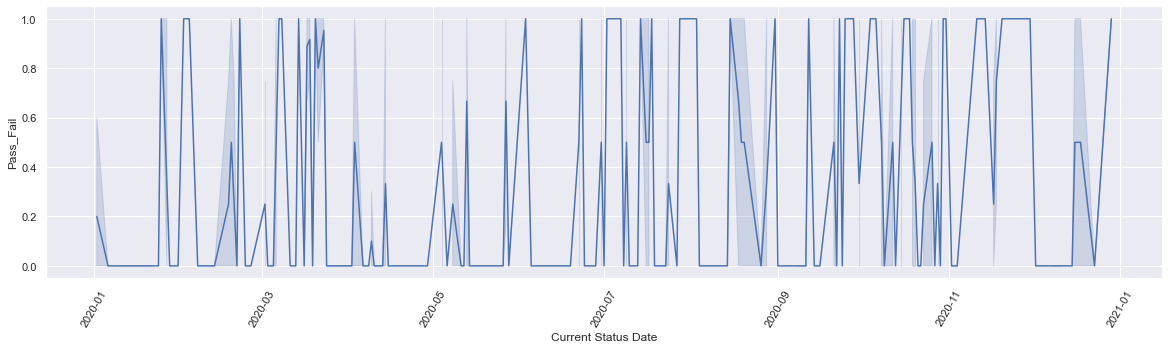

In [490]:
clean_dogs_2020_df = clean_new_dogs_df.loc[clean_new_dogs_df['Current Status Date'].dt.year == 2020]
sns.lineplot(data=clean_dogs_2020_df, x='Current Status Date', y='Pass_Fail')
plt.xticks(rotation = 60)
sns.set(rc={"figure.figsize":(20, 5)})
plt.show

The lineplot right below shows the distribution of how many dogs pass per month in the year 2021.

<function matplotlib.pyplot.show(close=None, block=None)>

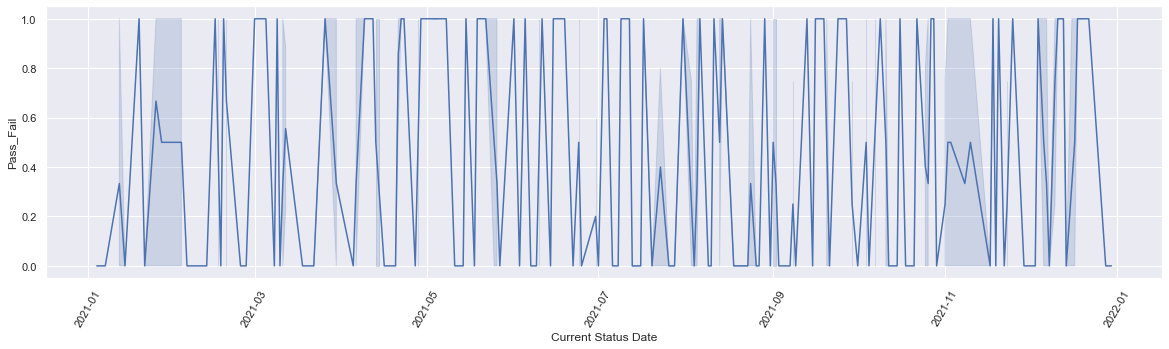

In [491]:
clean_dogs_2021_df = clean_new_dogs_df.loc[clean_new_dogs_df['Current Status Date'].dt.year == 2021]
sns.lineplot(data=clean_dogs_2021_df, x='Current Status Date', y='Pass_Fail')
plt.xticks(rotation = 60)
sns.set(rc={"figure.figsize":(20, 5)})
plt.show

The lineplot right below shows the distribution of how many dogs pass per month in the year 2022.

<function matplotlib.pyplot.show(close=None, block=None)>

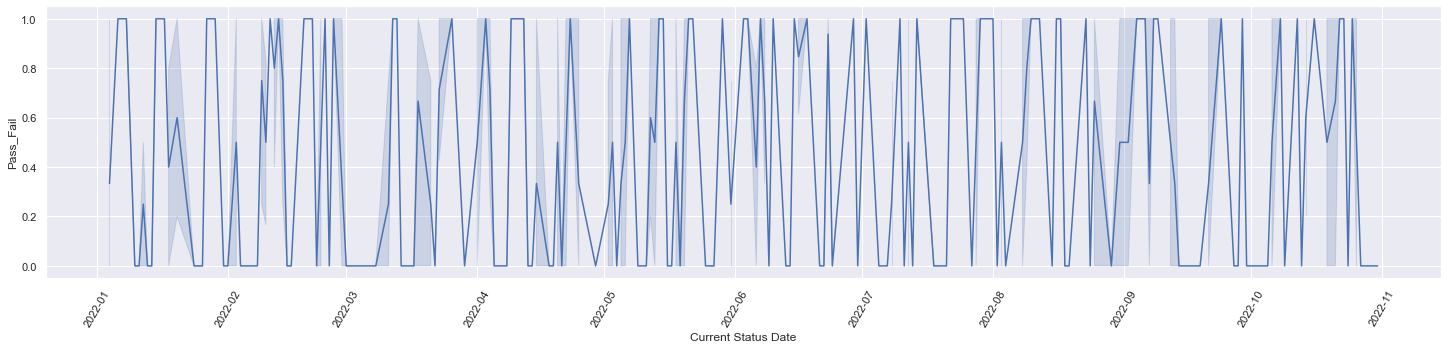

In [494]:
clean_dogs_2022_df = clean_new_dogs_df.loc[clean_new_dogs_df['Current Status Date'].dt.year == 2022]
sns.lineplot(data=clean_dogs_2022_df, x='Current Status Date', y='Pass_Fail')
plt.xticks(rotation = 60)
sns.set(rc={"figure.figsize":(25, 5)})
plt.show

### Birthdate

A similar summarization of the birthdate variable can be run. We can groupby this column to see how many dogs have passed who were born in 2015 and after, which is show below.

In [495]:
birthdate_df = clean_new_dogs_df[['Birthdate', 'Pass_Fail']].groupby(clean_new_dogs_df['Birthdate'].dt.year).sum()
birthdate_df

Pass_Fail
Birthdate           
2015             338
2016             348
2017             236
2018             142
2019             211
2020              67
2021              52
2022              56

The mean, standard deviation, and variance of these pass counts are shown below.

In [496]:
birthdate_df['Pass_Fail'].mean()

181.25

In [497]:
birthdate_df['Pass_Fail'].std()

121.44693138509982

In [498]:
birthdate_df['Pass_Fail'].var()

14749.357142857143

From this table, we can see that the birth year with the most passing dogs is 2016 with 348 dogs. The birth year with the lowest number of passing dogs is 2021 with only 52 dogs. In general, there is a sharp decline in number of dogs passing from the birth year of 2019 to the birth year of 2020, and it has stayed low since.

We can display the distribution of how many dogs pass per birth year via a lineplot. Said lineplot is shown below.

<function matplotlib.pyplot.show(close=None, block=None)>

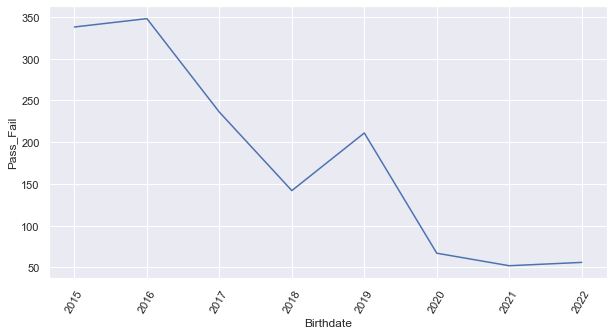

In [500]:
sns.lineplot(data=birthdate_df, x='Birthdate', y='Pass_Fail')
plt.xticks(rotation = 60)
sns.set(rc={"figure.figsize":(10, 5)})
plt.show

We can break this data down farther to see a distribution of how many dogs are passing per birthdate (in term on the month in a given year) via a lineplot.

The lineplot right below shows the distribution of how many dogs pass per month in the birth year 2020.

<function matplotlib.pyplot.show(close=None, block=None)>

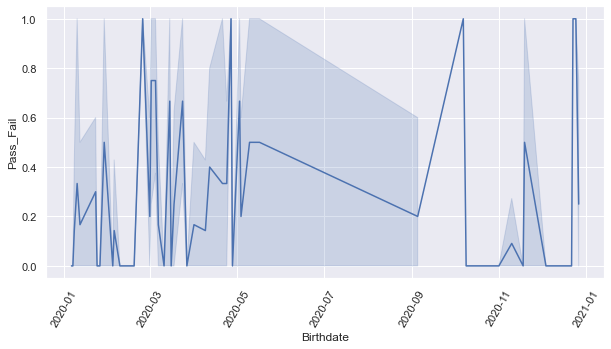

In [501]:
birthdate_2020_df = clean_new_dogs_df.loc[clean_new_dogs_df['Birthdate'].dt.year == 2020]
sns.lineplot(data=birthdate_2020_df, x='Birthdate', y='Pass_Fail')
plt.xticks(rotation = 60)
plt.show

The lineplot right below shows the distribution of how many dogs pass per month in the birth year 2021.

<function matplotlib.pyplot.show(close=None, block=None)>

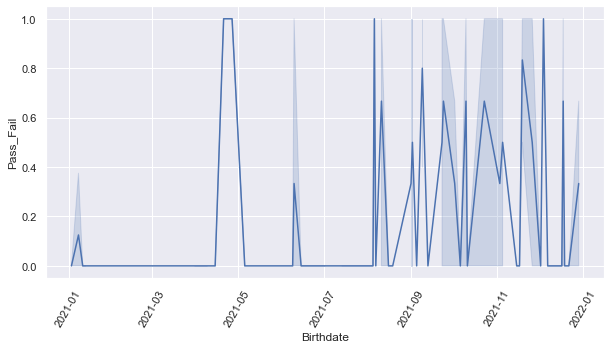

In [502]:
birthdate_2021_df = clean_new_dogs_df.loc[clean_new_dogs_df['Birthdate'].dt.year == 2021]
sns.lineplot(data=birthdate_2021_df, x='Birthdate', y='Pass_Fail')
plt.xticks(rotation = 60)
plt.show

The lineplot right below shows the distribution of how many dogs pass per month in the birth year 2022.

<function matplotlib.pyplot.show(close=None, block=None)>

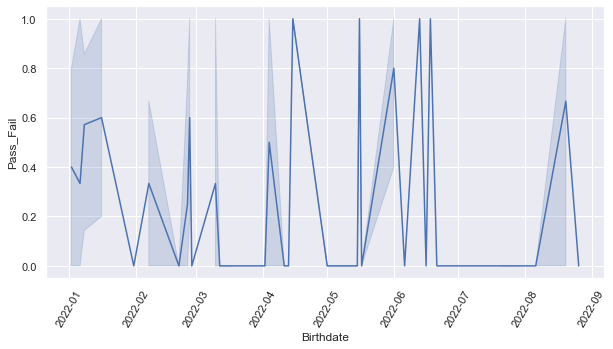

In [503]:
birthdate_2022_df = clean_new_dogs_df.loc[clean_new_dogs_df['Birthdate'].dt.year == 2022]
sns.lineplot(data=birthdate_2022_df, x='Birthdate', y='Pass_Fail')
plt.xticks(rotation = 60)
plt.show

It is also worth noting the frequency of birthdates per year in general, as well as the mean, standard deviation, and variance of these frequencies as shown below:

In [504]:
clean_new_dogs_df['Birthdate'].dt.year.value_counts()

2016    604
2015    566
2017    551
2019    474
2018    404
2020    238
2021    173
2022    124
Name: Birthdate, dtype: int64

In [505]:
clean_new_dogs_df['Birthdate'].dt.year.value_counts().mean()

391.75

In [506]:
clean_new_dogs_df['Birthdate'].dt.year.value_counts().std()

189.3105913571663

In [507]:
clean_new_dogs_df['Birthdate'].dt.year.value_counts().var()

35838.5

Now that we have a better understanding of the dates related to our dogs, lets now get a better understanding of the other characteristics of ours dogs that could have an impact on the probability of passing the final exam, such as gender, breed, mom, and dad.

But first and foremost, let's assess pass fail count in general.

### Pass_Fail

Based on the code below, we have 3,134 dogs for which we know whether or not they passed or failed. 1684 of the 3134 dogs failed, while 1450 passed. In percentages, that means about 54% failed and 46% passed.

In [508]:
pd.crosstab(index=clean_new_dogs_df['Pass_Fail'], columns='count')

col_0      count
Pass_Fail       
False       1684
True        1450

In [509]:
pd.crosstab(index=clean_new_dogs_df['Pass_Fail'], columns='count', normalize = 'columns')

col_0         count
Pass_Fail          
False      0.537332
True       0.462668

**Drawing a comparison:** For comparison, in our original dataset, we only had 474 dogs for which we knew whether or not they passed or failed. 335 of the 474 dogs failed, while 139 passed. In percentages, that meant about 70% failed and 30% passed. By comparison, our new dataset has a much more even split. This is a very good sign because, a very low pass rate for dogs (which is what our original dataset had) could easily cause the model we build to have a deceptively high accuracy (because predicting failure all the time would technically be accurate).

If you are curious to know where these numbers from the original dataset came from, view the code below.

In [512]:
clean_dogs_df = pd.read_csv('clean_dog_data.csv')
clean_dogs_df = clean_dogs_df.drop(columns = ['Unnamed: 0'])

In [514]:
pd.crosstab(index=clean_dogs_df['Pass_Fail'], columns='count')

col_0      count
Pass_Fail       
False        335
True         139

In [513]:
pd.crosstab(index=clean_dogs_df['Pass_Fail'], columns='count', normalize = 'columns')

col_0         count
Pass_Fail          
False      0.706751
True       0.293249

These counts can be displayed via the countplot below. (Note: just to be clear, we mean counts from our new dataset, not the original!)

<function matplotlib.pyplot.show(close=None, block=None)>

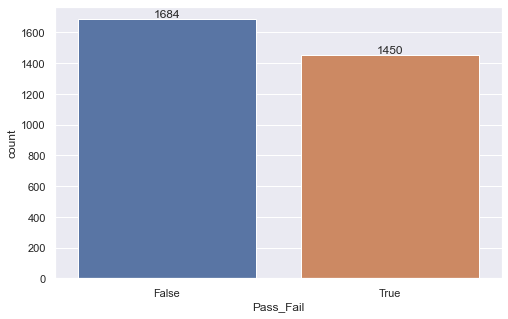

In [517]:
passfail_countplot = sns.countplot(data=clean_new_dogs_df, x='Pass_Fail')
passfail_countplot.bar_label(passfail_countplot.containers[0])
sns.set(rc={"figure.figsize":(8, 5)})
plt.show

The blue bar in the countplot represents the number of dogs who have failed their final exam (it is labeled False because False in this context means fail), whereas the orange bar represents the number of dogs who passed their final exam (it is labeled True because True in this context means pass). Notice how the heights of the bars are not noticeably far off, but the blue bar is higher than the orange bar.

It is also worth assessing the number of dogs for which we can predict the probability of passing or failing the final exam. The dogs_to_predict_df has 665 rows, meaning we have 665 dogs for which we can try to predict the liklihood of them passing the final exam.

In [561]:
new_dogs_to_predict_df.shape

(665, 10)

### Gender

We can find the frequency of being either a male or female dog using the pd.crosstab() function, as well as the percentage who are either male or female, as shown below.

In [562]:
pd.crosstab(index=clean_new_dogs_df['Gender'], columns='count')

col_0   count
Gender       
Female   1490
Male     1644

In [563]:
pd.crosstab(index=clean_new_dogs_df['Gender'], columns='count', normalize='columns')

col_0      count
Gender          
Female  0.475431
Male    0.524569

Now lets assess the connection between Gender and Pass_Fail, again using pd.crosstab(). If we set the argument normalize = 'index', we can see that around 55.23% of female dogs fail the final exam, while around 44.77% pass. For male dogs, around 52.37% fail, and 47.63% pass.

In [566]:
pd.crosstab(index=clean_new_dogs_df['Gender'], columns=clean_new_dogs_df['Pass_Fail'])

Pass_Fail  False  True
Gender                
Female       823   667
Male         861   783

In [567]:
pd.crosstab(index=clean_new_dogs_df['Gender'], columns=clean_new_dogs_df['Pass_Fail'], normalize='index')

Pass_Fail     False      True
Gender                       
Female     0.552349  0.447651
Male       0.523723  0.476277

We can visualize these counts via the mosaic plot and the count plot below.

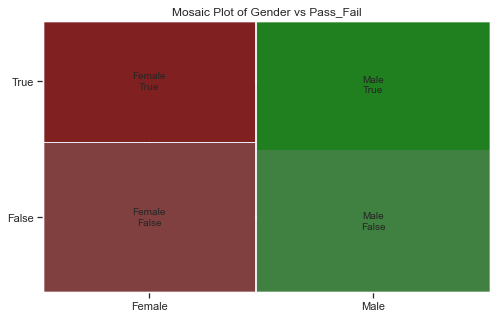

In [569]:
mosaic(clean_new_dogs_df, ['Gender', 'Pass_Fail'], title = 'Mosaic Plot of Gender vs Pass_Fail')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

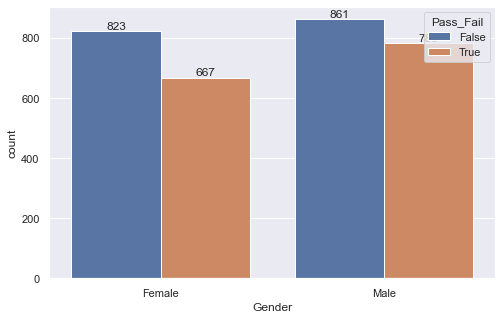

In [570]:
gender_countplot = sns.countplot(data=clean_new_dogs_df, x='Gender', hue="Pass_Fail")
gender_countplot.bar_label(gender_countplot.containers[0])
gender_countplot.bar_label(gender_countplot.containers[1])
sns.set(rc={"figure.figsize":(8, 5)})
plt.show

We can also visualize the pass/fail percentages via the barplot shown below.

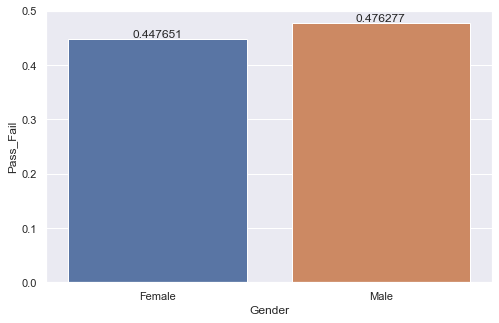

In [571]:
gender_barplot = sns.barplot(x='Gender', y='Pass_Fail', data=clean_new_dogs_df, ci=None)
gender_barplot.bar_label(gender_barplot.containers[0])
sns.set(rc={"figure.figsize":(5, 5)})

It is also worth looking again at the dogs we will eventually try to predict, and the gender counts/frequencies of the dogs in this dataset.

In [572]:
pd.crosstab(index=new_dogs_to_predict_df['Gender'], columns='count')

col_0   count
Gender       
Female    317
Male      348

In [573]:
pd.crosstab(index=new_dogs_to_predict_df['Gender'], columns='count', normalize='columns')

col_0      count
Gender          
Female  0.476692
Male    0.523308

<function matplotlib.pyplot.show(close=None, block=None)>

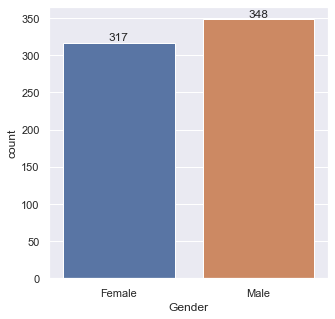

In [574]:
predict_gender_countplot = sns.countplot(data=new_dogs_to_predict_df, x='Gender')
predict_gender_countplot.bar_label(predict_gender_countplot.containers[0])
sns.set(rc={"figure.figsize":(8, 5)})
plt.show

### Breed

We can find the frequency of being a Labrador Retriever (LR) or a German Shepherd (GS) using the pd.crosstab() function, as well as the percentage who are either LR or GS, as shown below.

In [575]:
pd.crosstab(index=clean_new_dogs_df['Breed'], columns='count')

col_0  count
Breed       
GS       315
LR      2819

In [576]:
pd.crosstab(index=clean_new_dogs_df['Breed'], columns='count', normalize='columns')

col_0     count
Breed          
GS     0.100511
LR     0.899489

Now lets assess the connection between Breed and Pass_Fail, again using pd.crosstab(). If we set the argument normalize = 'index', we can see that around 53% of GS fail the final exam, while around 47% pass. For LR, around 54% fail, and 46% pass.

It is also interesting to note how GS has a greater percentage of passing, yet they are bred far less often than LR.

In [577]:
pd.crosstab(index=clean_new_dogs_df['Breed'], columns=clean_new_dogs_df['Pass_Fail'])

Pass_Fail  False  True
Breed                 
GS           168   147
LR          1516  1303

In [578]:
pd.crosstab(index=clean_new_dogs_df['Breed'], columns=clean_new_dogs_df['Pass_Fail'], normalize='index')

Pass_Fail     False      True
Breed                        
GS         0.533333  0.466667
LR         0.537779  0.462221

We can visualize these counts via the mosaic plot and the count plot below.

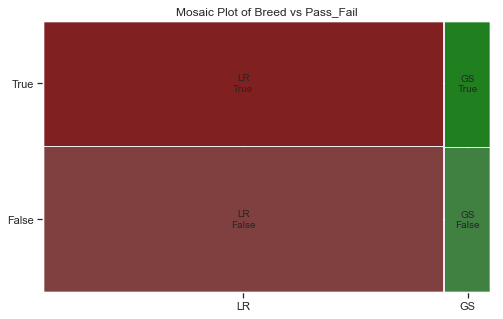

In [579]:
mosaic(clean_new_dogs_df, ['Breed', 'Pass_Fail'], title = 'Mosaic Plot of Breed vs Pass_Fail')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

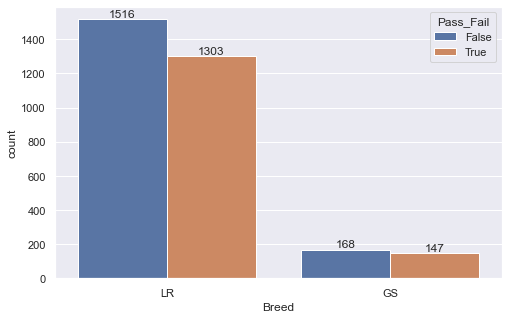

In [580]:
breed_countplot = sns.countplot(data=clean_new_dogs_df, x='Breed', hue="Pass_Fail")
breed_countplot.bar_label(breed_countplot.containers[0])
breed_countplot.bar_label(breed_countplot.containers[1])
sns.set(rc={"figure.figsize":(8, 5)})
plt.show

We can also visualize the pass/fail percentages via the barplot shown below.

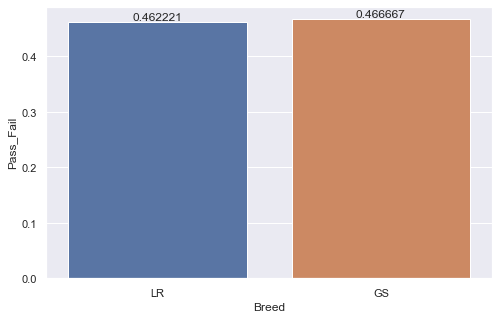

In [581]:
breed_barplot = sns.barplot(x='Breed', y='Pass_Fail', data=clean_new_dogs_df, ci=None)
breed_barplot.bar_label(breed_barplot.containers[0])
sns.set(rc={"figure.figsize":(5, 5)})

### Sire

We can find the frequency of having each sire (dad) using the pd.crosstab() function, as well as the percentage having each dad, as shown below. It appears that the most common sire is `Donald - P - 9D14 - LRBM` with 96 kids.

In [582]:
pd.crosstab(index=clean_new_dogs_df['Sire'], columns='count')

col_0                            count
Sire                                  
Able - 3A311 - LRBM                 25
Ace - 6A414 - LRBM                   4
Adam 2 - 6A415 - LRYM               41
Alan - 8A411 - LRBM                  9
Alvin - 7A513 - LRYM                 9
...                                ...
Will GBBA - WILL1 - LRBM *NOP*       9
Yarmouth - 2YY18 - LRYM             13
Young - 9Y14 - LRYM                 22
Zach TSE - ZACH - GSSABLM *NOP*      1
Zinc - 8ZZ17 - LRYM                 53

[163 rows x 1 columns]

In [583]:
clean_new_dogs_df['Sire'].value_counts()

Donald - P - 9D14 - LRBM                   96
Vito - 7VV14 - LRBM                        79
Sierra KNGF - SIERRA - LRBM *NOP*          75
Chester - 1CC15 - LRBM                     74
Carlos - 5C15 - LRBM                       72
                                           ..
Trent TSE - TRENT - GSB&TM *NOP*            1
Jensen - 7J409 - LRYM                       1
Arby - 5A319 - LRBM                         1
Timber FGDF - TIMBER FGD - GSB&TM *NOP*     1
Rugby - 2R319 - GSSABLM                     1
Name: Sire, Length: 163, dtype: int64

In [584]:
pd.crosstab(index=clean_new_dogs_df['Sire'], columns='count', normalize = 'columns')

col_0                               count
Sire                                     
Able - 3A311 - LRBM              0.007977
Ace - 6A414 - LRBM               0.001276
Adam 2 - 6A415 - LRYM            0.013082
Alan - 8A411 - LRBM              0.002872
Alvin - 7A513 - LRYM             0.002872
...                                   ...
Will GBBA - WILL1 - LRBM *NOP*   0.002872
Yarmouth - 2YY18 - LRYM          0.004148
Young - 9Y14 - LRYM              0.007020
Zach TSE - ZACH - GSSABLM *NOP*  0.000319
Zinc - 8ZZ17 - LRYM              0.016911

[163 rows x 1 columns]

Now lets assess the connection between Sire and Pass_Fail by getting the counts and percentages of passing and failing. It appears that `Donald - P - 9D14 - LRBM` is also the sire connected to the most passes at a count of 77 passing pups.

In [585]:
pd.crosstab(index=clean_new_dogs_df['Sire'], columns=clean_new_dogs_df['Pass_Fail'])

Pass_Fail                        False  True
Sire                                        
Able - 3A311 - LRBM                 10    15
Ace - 6A414 - LRBM                   2     2
Adam 2 - 6A415 - LRYM               21    20
Alan - 8A411 - LRBM                  4     5
Alvin - 7A513 - LRYM                 6     3
...                                ...   ...
Will GBBA - WILL1 - LRBM *NOP*       0     9
Yarmouth - 2YY18 - LRYM             10     3
Young - 9Y14 - LRYM                  9    13
Zach TSE - ZACH - GSSABLM *NOP*      0     1
Zinc - 8ZZ17 - LRYM                 25    28

[163 rows x 2 columns]

In [586]:
pass_dogs_df = clean_new_dogs_df.loc[clean_new_dogs_df['Pass_Fail']==1]
pass_dogs_df.head()
pass_dogs_df['Sire'].value_counts()

Donald - P - 9D14 - LRBM             77
Maestro - 5M411 - LRYM               59
Vito - 7VV14 - LRBM                  45
Sierra KNGF - SIERRA - LRBM *NOP*    43
Florian - S - 2F415 - LRYM           36
                                     ..
Disney - 7D419 - LRB&TM               1
Rugby - 2R319 - GSSABLM               1
Elton - 4EE20 - LRBM                  1
Wiggins - 8WW19 - LRBM                1
Flanders - 3F318 - LRYM               1
Name: Sire, Length: 137, dtype: int64

In [587]:
pd.crosstab(index=clean_new_dogs_df['Sire'], columns=clean_new_dogs_df['Pass_Fail'], normalize = 'index')

Pass_Fail                           False      True
Sire                                               
Able - 3A311 - LRBM              0.400000  0.600000
Ace - 6A414 - LRBM               0.500000  0.500000
Adam 2 - 6A415 - LRYM            0.512195  0.487805
Alan - 8A411 - LRBM              0.444444  0.555556
Alvin - 7A513 - LRYM             0.666667  0.333333
...                                   ...       ...
Will GBBA - WILL1 - LRBM *NOP*   0.000000  1.000000
Yarmouth - 2YY18 - LRYM          0.769231  0.230769
Young - 9Y14 - LRYM              0.409091  0.590909
Zach TSE - ZACH - GSSABLM *NOP*  0.000000  1.000000
Zinc - 8ZZ17 - LRYM              0.471698  0.528302

[163 rows x 2 columns]

We can visualize these percentages via the bar plot below, and then visualize the counts via the countplot below.

<function matplotlib.pyplot.show(close=None, block=None)>

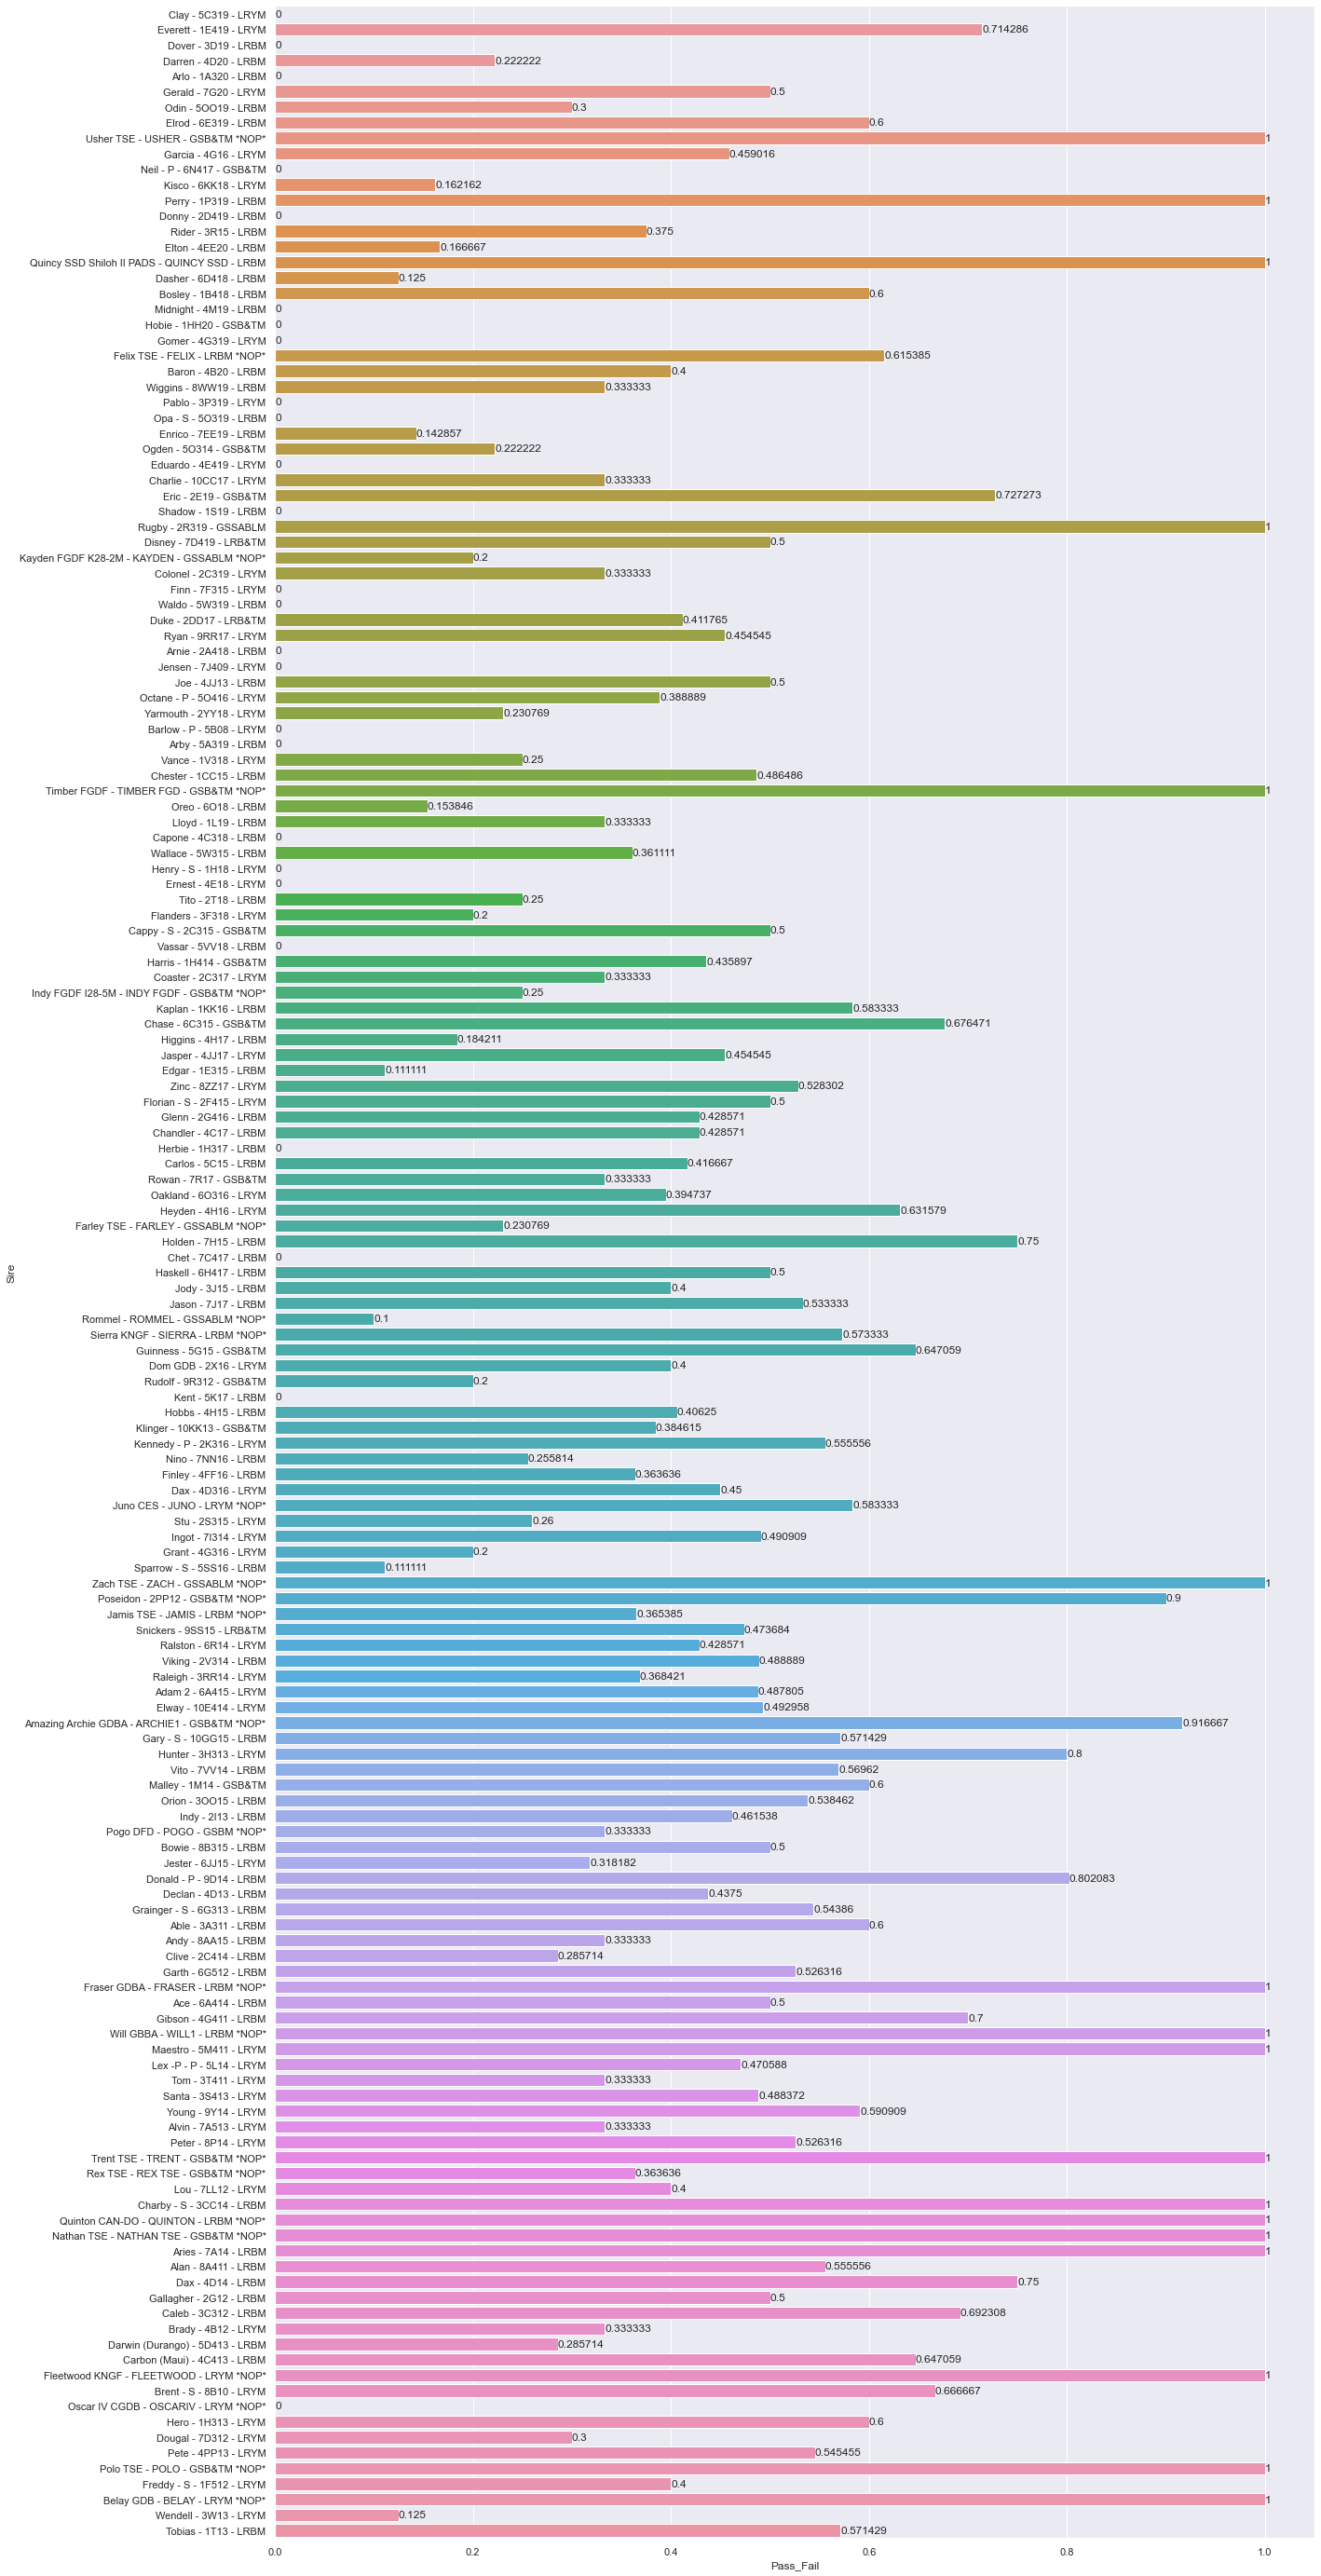

In [589]:
sire_barplot = sns.barplot(x="Pass_Fail", y='Sire', data=clean_new_dogs_df, ci=None)
#plt.figure(figsize=(300,100))
sire_barplot.bar_label(sire_barplot.containers[0])
sns.set(rc={"figure.figsize":(20, 50)})
plt.show

What this barplot is showing you is the percentage of pups that pass their final exam for every type of sire. For example, if you look above and view the very last bar for the sire named `Tobias - 1T13 - LRBM`, you see that his bar is labeled with the value 0.571429, meaning that around 57% of his pups pass their final exam. Some sires have a pass rate of 100%, which is equivalent to have a bar height of 1. Example of these kinds of sires are Belay, Zach, and Will. Sires with no bars and a value of 0 mean that none of their pups have passed their final exam. An example of this is the very first Sire listed in the barplot (Clay).

<function matplotlib.pyplot.show(close=None, block=None)>

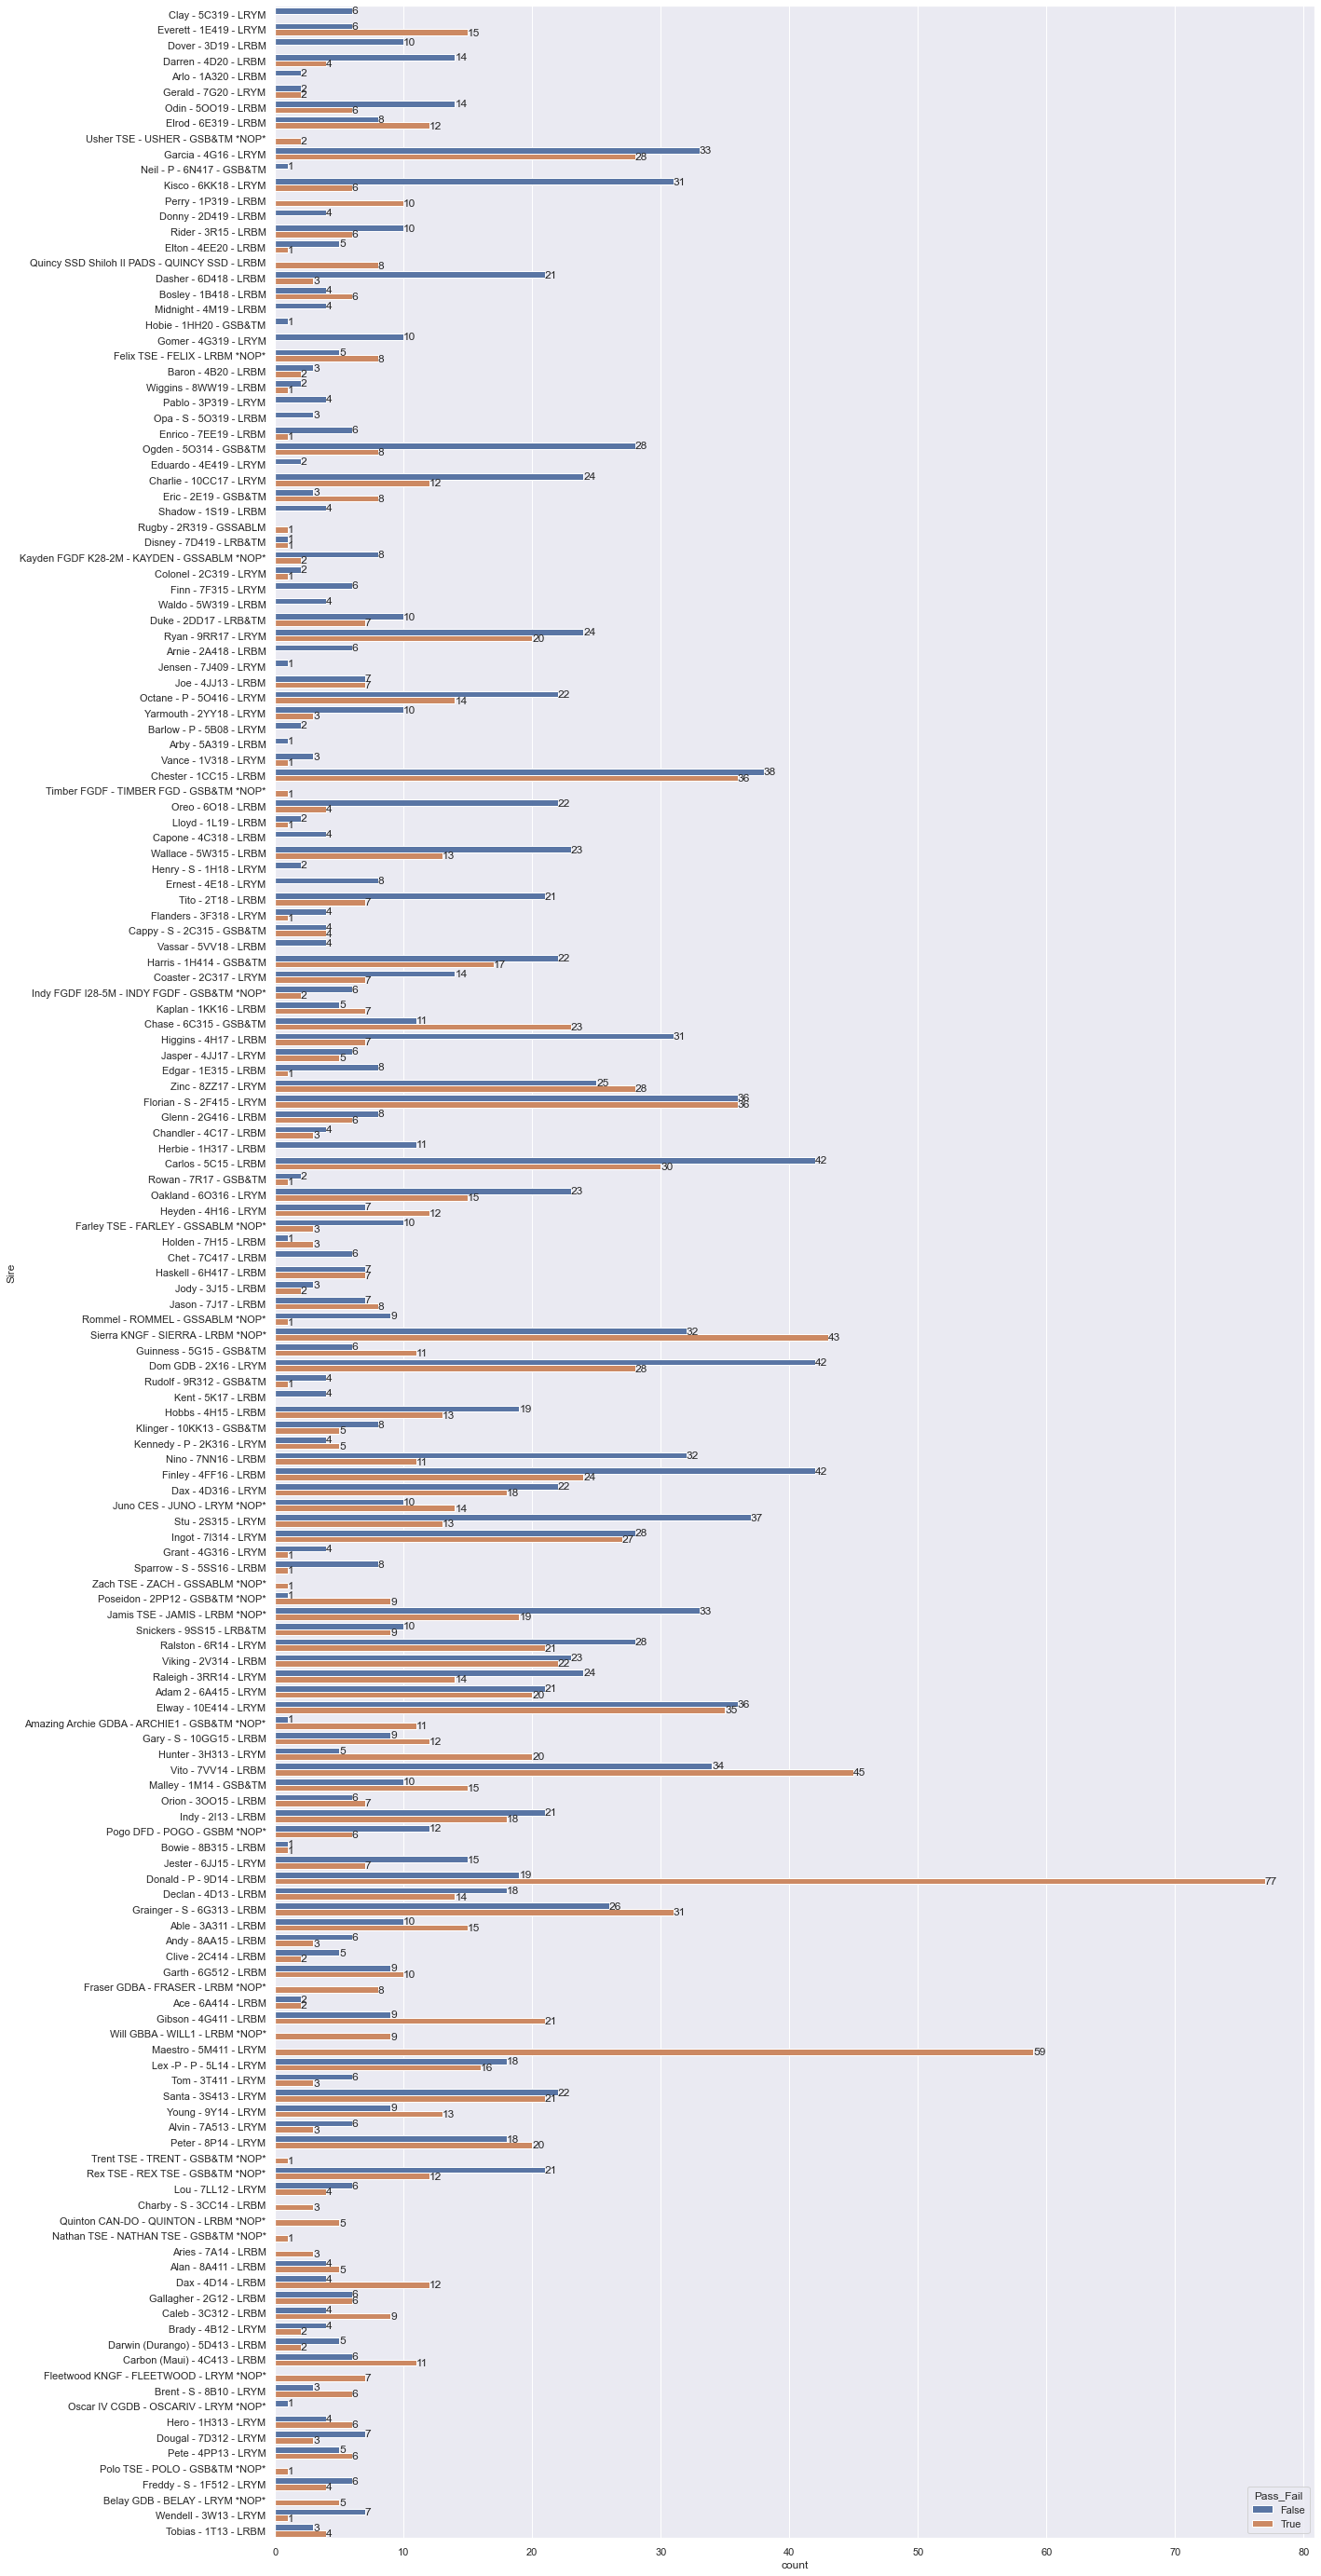

In [590]:
sire_countplot = sns.countplot(data=clean_new_dogs_df, y='Sire', hue="Pass_Fail")
sire_countplot.bar_label(sire_countplot.containers[0])
sire_countplot.bar_label(sire_countplot.containers[1])
sns.set(rc={"figure.figsize":(20, 50)})
plt.show

What this countplot is showing you is the counts of pups who fail their final exam and pass their final exam per sire. The blue bar is the count of pups who fail their final exam for that sire, and the orange bar right below it is the count of pups who passed their final exam for that same sire (this is also outlined in the legend). For example, if you look above and view the very last bars for the sire named `Tobias - 1T13 - LRBM`, you can see that he has had 3 pups who have failed, and 4 pups who have passed. If a sire has no blue bar, then that means none of their pups have failed. If a sire has no orange bar, then that means none of their pups have passed.

### Dam

We can find the frequency of having each dam (mom) using the pd.crosstab() function, as well as the percentage having each mom, as shown below. It appears that the most common dam is `Tessa - 7T13 - LRBF` with 39 kids.

In [596]:
pd.crosstab(index=clean_new_dogs_df['Dam'], columns='counts')

col_0                             counts
Dam                                     
Abba - 5AA15 - LRBF                   22
Addison - P - 1AA11 - LRYF             8
Adrienne - 9A418 - LRBF                3
Aggie - S - 1A313 - LRBF              18
Ali SSD - ALI - LRYF *NOP*             8
...                                  ...
Yoshi - 1Y17 - LRYF                   14
Zambi CGDB - ZAMBI1 - LRBF *NOP*       1
Zayna - 5Z319 - LRYF                   1
Zelda - 1Z319 - LRBF                   2
Zula - S - 4A317 - LRYF                8

[282 rows x 1 columns]

In [597]:
clean_new_dogs_df['Dam'].value_counts()

Tessa - 7T13 - LRBF                  39
Erin - P - 5E315 - LRCHOCF           38
Dorothy - 6D13 - LRBF                37
Lizzie - 6L315 - LRBF                33
Flossie - 4F13 - LRBF                32
                                     ..
Tawny - 1T318 - GSSABLF               1
Janet - 2J20 - LRYF                   1
Xena - 2X20 - GSB&TF                  1
Cathy TSE - CATHY - GSSABLF *NOP*     1
Demi - 5D319 - LRYF                   1
Name: Dam, Length: 282, dtype: int64

In [598]:
pd.crosstab(index=clean_new_dogs_df['Dam'], columns='counts', normalize = 'columns')

col_0                               counts
Dam                                       
Abba - 5AA15 - LRBF               0.007020
Addison - P - 1AA11 - LRYF        0.002553
Adrienne - 9A418 - LRBF           0.000957
Aggie - S - 1A313 - LRBF          0.005743
Ali SSD - ALI - LRYF *NOP*        0.002553
...                                    ...
Yoshi - 1Y17 - LRYF               0.004467
Zambi CGDB - ZAMBI1 - LRBF *NOP*  0.000319
Zayna - 5Z319 - LRYF              0.000319
Zelda - 1Z319 - LRBF              0.000638
Zula - S - 4A317 - LRYF           0.002553

[282 rows x 1 columns]

Now lets assess the connection between Dam and Pass_Fail by getting the counts and percentages of passing and failing. It appears that `PBBSophie - PBBSophie - LRYF *NOP*` is the dam connected to the most passes at a count of 22 passing pups.

In [599]:
pd.crosstab(index=clean_new_dogs_df['Dam'], columns=clean_new_dogs_df['Pass_Fail'])

Pass_Fail                         False  True
Dam                                          
Abba - 5AA15 - LRBF                  12    10
Addison - P - 1AA11 - LRYF            4     4
Adrienne - 9A418 - LRBF               3     0
Aggie - S - 1A313 - LRBF              8    10
Ali SSD - ALI - LRYF *NOP*            0     8
...                                 ...   ...
Yoshi - 1Y17 - LRYF                  10     4
Zambi CGDB - ZAMBI1 - LRBF *NOP*      1     0
Zayna - 5Z319 - LRYF                  1     0
Zelda - 1Z319 - LRBF                  1     1
Zula - S - 4A317 - LRYF               5     3

[282 rows x 2 columns]

In [600]:
pass_dogs_df['Dam'].value_counts()

PBBSophie - PBBSophie - LRYF *NOP*      22
Rasha - 2R314 - GSB&TF *NOP*            20
Delphi - 7D413 - LRYF                   17
Sugar - 2S413 - LRYF *NOP*              17
Dakota - S - 4D417 - LRBF *NOP*         17
                                        ..
Oats - 7OO17 - LRBF                      1
Camille - 5C417 - LRBF                   1
Elise TSE - ELISE TSE - GSB&TF *NOP*     1
Ona - 6O19 - LRBF                        1
Lace - 8L18 - LRBF                       1
Name: Dam, Length: 239, dtype: int64

In [601]:
pd.crosstab(index=clean_new_dogs_df['Dam'], columns=clean_new_dogs_df['Pass_Fail'], normalize = 'index')

Pass_Fail                            False      True
Dam                                                 
Abba - 5AA15 - LRBF               0.545455  0.454545
Addison - P - 1AA11 - LRYF        0.500000  0.500000
Adrienne - 9A418 - LRBF           1.000000  0.000000
Aggie - S - 1A313 - LRBF          0.444444  0.555556
Ali SSD - ALI - LRYF *NOP*        0.000000  1.000000
...                                    ...       ...
Yoshi - 1Y17 - LRYF               0.714286  0.285714
Zambi CGDB - ZAMBI1 - LRBF *NOP*  1.000000  0.000000
Zayna - 5Z319 - LRYF              1.000000  0.000000
Zelda - 1Z319 - LRBF              0.500000  0.500000
Zula - S - 4A317 - LRYF           0.625000  0.375000

[282 rows x 2 columns]

We can visualize these percentages via the bar plot below, and then visualize the counts via the countplot below.

<function matplotlib.pyplot.show(close=None, block=None)>

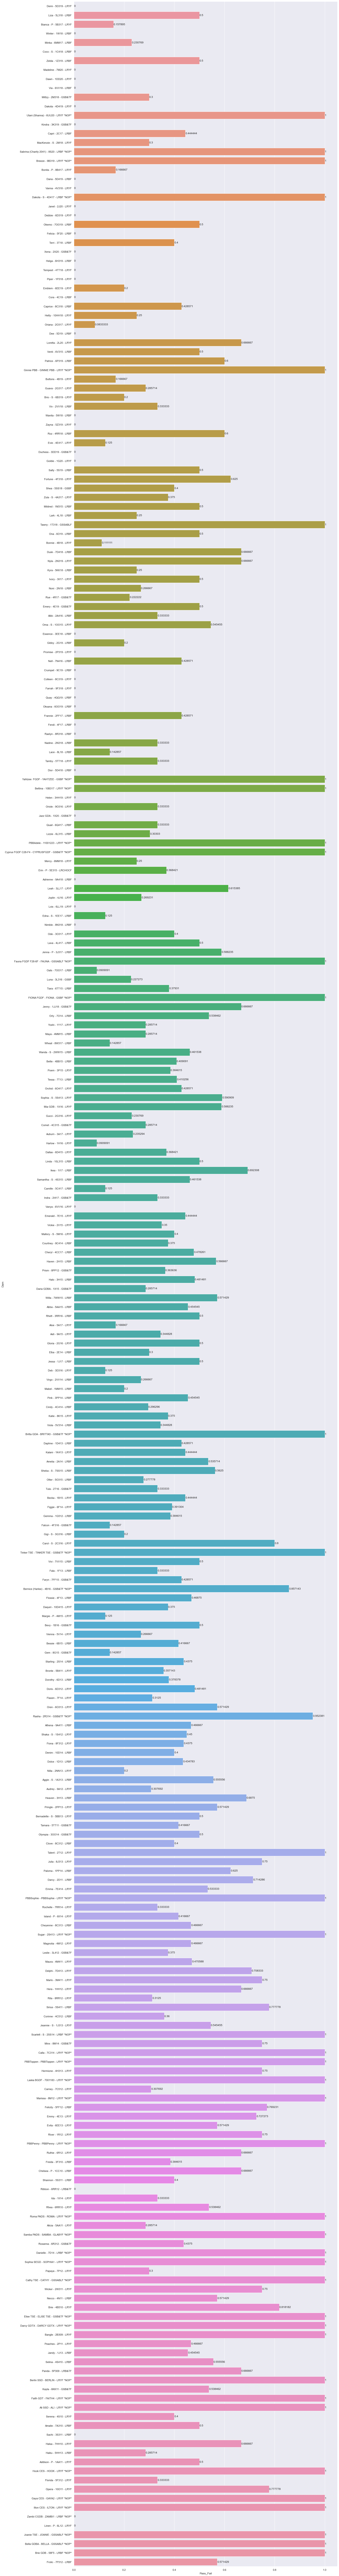

In [595]:
dam_barplot = sns.barplot(x="Pass_Fail", y='Dam', data=clean_new_dogs_df, ci=None)
dam_barplot.bar_label(dam_barplot.containers[0])
sns.set(rc={"figure.figsize":(20, 50)})
plt.show

What this barplot is showing you is the percentage of pups that pass their final exam for every type of dam. For example, if you look above and view the very last bar for the dam named `Frolic - 7F512 - LRBF`, you see that her bar is labeled with the value 0.571429, meaning that around 57% of her pups pass their final exam. Some dams have a pass rate of 100%, which is equivalent to have a bar height of 1. Example of these kinds of sires are Joanie, Bella, and Brie. Dams with no bars and a value of 0 mean that none of their pups have passed their final exam. An example of this is Zambi and Linen (at the bottom of the plot).

<function matplotlib.pyplot.show(close=None, block=None)>

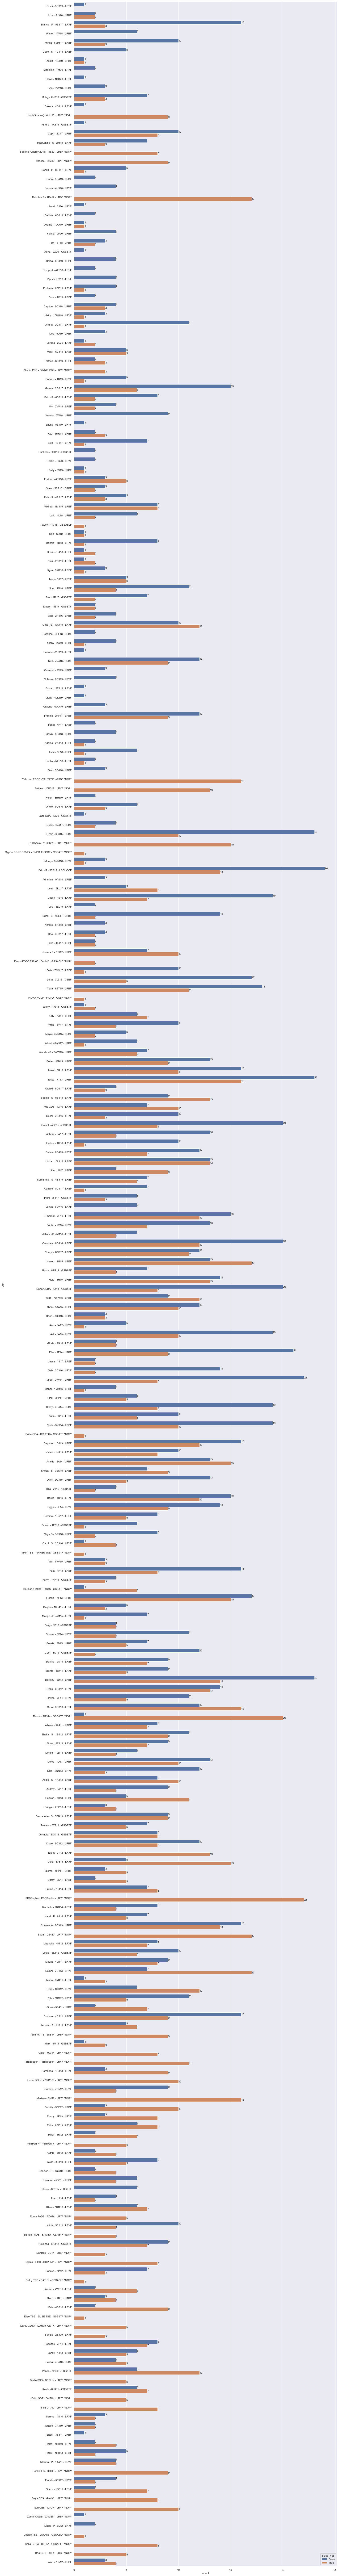

In [594]:
dam_countplot = sns.countplot(data=clean_new_dogs_df, y='Dam', hue="Pass_Fail")
dam_countplot.bar_label(dam_countplot.containers[0])
dam_countplot.bar_label(dam_countplot.containers[1])
sns.set(rc={"figure.figsize":(20, 200)})
plt.show

What this countplot is showing you is the counts of pups who fail their final exam and pass their final exam per dam. The blue bar is the count of pups who fail their final exam for that dam, and the orange bar right below it is the count of pups who passed their final exam for that same dam (this is also outlined in the legend). For example, if you look above and view the very last bars for the dam named `Frolic - 7F512 - LRBF`, you can see that she has had 3 pups who have failed, and 4 pups who have passed. If a dam has no blue bar, then that means none of their pups have failed. If a dam has no orange bar, then that means none of their pups have passed.

### Connecting data analysis to research question

Based on our data analysis, we can confirm that we want to continue with our research question and hypothis tests. Our research question aims to assess the influence of certain dog traits on the ability to pass or fail the final exam, and after viewing summary statistics related to each factor, we find that this research question is still worth pursuing. For example, there are some stand out fathers and mothers that have a high percentage of successful children, which makes us think this is worth deep diving into via our two hypothis tests.

# Evaluation of Significance

## Hypothesis 1 (Dam and Pass_Fail)

To recap, hypothesis 1 is as follows:
- Null Hypothesis: Who the dam (mother) is does not impact the probability of passing the final exam [so all $𝜷_{dam_i} = 0$ where variable i denotes the name of some dam since we do not know which exact dam may have a significant impact)].
- Alternative Hypothesis: Who the dam is significantly impacts the probability of passing the final exam, either negatively or positively [at least one dam so $𝜷_{dam_i} > 0$ and/or  $𝜷_{dam_i} < 0$ (> 0 means that this dam will increase the probability of passing, and < 0 means this dam will decrease the probability)].

### Model

The first part of tackling this hypothesis test is to create a regression that we can later compare to simple randomness.

Because we want to determine how the value of a categorical variable (Dam) impacts the binary output of either passing or failing (where passing = 1 and failing = 0), we will utilizing a logistic regression model for binary outputs.

Because our inputs would be the names of different moms, we will make the values of `Dam` into quantifiable binary inputs by creating a dummy table for `Dam`. The code that does this is shown below.

In [518]:
dam_dummy = pd.get_dummies(clean_new_dogs_df['Dam'], drop_first=True)
clean_new_dogs_df_copy = clean_new_dogs_df
clean_new_dogs_df_copy = pd.concat([clean_new_dogs_df_copy, dam_dummy], axis=1)

After creating this dummy table for Dam called `dam_dummy`, we created a copy of `clean_new_dogs_df` called `clean_new_dogs_df_copy`, which we will concatenate  `dam_dummy` along the columns (hence we used `axis=1`. Using this updated `clean_new_dogs_df_copy`, we will create a train/test split to create a training set called `dogs_train`, and a testing set called `dogs_test`. This is done in the code right below.

In [519]:
dogs_train, dogs_test = train_test_split(clean_new_dogs_df_copy, test_size=0.2, random_state=2777)

Now using `sklearn`, we will fit a Logistic Regression called `model` using our train test split that takes the different kinds of inputs for Dam (which in the code means `dam_dummy.columns`) and uses that to predict whether or not that dog passes or fails (so it predicts the `Pass_Fail` column value). Then we found and printed the train and test values for accuracy, precision, recall, and f1 scores for this logistic regression model. All these values are printed below.

In [535]:
model = LogisticRegression().fit(dogs_train[dam_dummy.columns], dogs_train['Pass_Fail'])
training_predictions = model.predict(dogs_train[dam_dummy.columns])
testing_predictions = model.predict(dogs_test[dam_dummy.columns])


train_accuracy = metrics.accuracy_score(dogs_train['Pass_Fail'], training_predictions)
test_accuracy = metrics.accuracy_score(dogs_test['Pass_Fail'], testing_predictions)
test_precision = metrics.precision_score(dogs_train['Pass_Fail'], training_predictions)
train_precision = metrics.precision_score(dogs_test['Pass_Fail'], testing_predictions)
train_recall = metrics.recall_score(dogs_train['Pass_Fail'], training_predictions)
test_recall = metrics.recall_score(dogs_test['Pass_Fail'], testing_predictions)
train_f1 = metrics.f1_score(dogs_train['Pass_Fail'], training_predictions)
test_f1 = metrics.f1_score(dogs_test['Pass_Fail'], testing_predictions)


print('the possible Dam inputs are:')
print(dam_dummy.columns)
print('the coefficient for each possible Dam input is')
print(model.coef_)
print('the intercept is',model.intercept_)
print('the train accuracy is',train_accuracy)
print('the test accuracy is',test_accuracy)
print('the train precision is',train_precision)
print('the test precision is',test_precision)
print('the train recall is',train_recall)
print('the test recall is',test_recall)
print('the train f1 score is',train_f1)
print('the test f1 score is',test_f1)

the possible Dam inputs are:
Index(['Addison - P - 1AA11 - LRYF', 'Adrienne - 9A418 - LRBF',
       'Aggie - S - 1A313 - LRBF', 'Ali SSD - ALI - LRYF *NOP*',
       'Alibi - 2A416 - LRBF', 'Alicia - 5AA11 - LRYF', 'Aloe - 5A17 - LRYF',
       'Amalie - 7A310 - LRBF', 'Amelia - 2A14 - LRBF', 'Asti - 9A15 - LRYF',
       ...
       'Wicker - 2W311 - LRYF', 'Willa - 7WW15 - LRBF', 'Winter - 1W18 - LRBF',
       'Xena - 2X20 - GSB&TF', 'Yahtzee  FGDF - YAHTZEE - GSBF *NOP*',
       'Yoshi - 1Y17 - LRYF', 'Zambi CGDB - ZAMBI1 - LRBF *NOP*',
       'Zayna - 5Z319 - LRYF', 'Zelda - 1Z319 - LRBF',
       'Zula - S - 4A317 - LRYF'],
      dtype='object', length=281)
the coefficient for each possible Dam input is
[[ 0.09437031 -0.8202514   0.44153559  1.37249294  0.05242202 -0.48408509
  -0.9748742   0.72423575 -0.17716646 -0.39615919  0.10486847 -0.64456828
  -0.47337691  0.72423575  0.13312851  1.47653919  1.25271969  0.22951279
   1.25271969  0.10486847  0.0319893   1.79329239  0.09437031 -1.

This is how you should interpret the output above:

The list of possible Dam inputs lines up with the list of coefficients for each possible Dam input. For example, `Addison - P - 1AA11 - LRYF` is the first dam listed and has the coefficient of 0.09437031 (because that is the first coefficient listed), `Adrienne - 9A418 - LRBF` has the coefficient of -0.8202514, so on and so forth.

What it means for `Addison - P - 1AA11 - LRYF` to have a coefficient of 0.09437031 is that, when a pup has Addison as their dam (mother), then the expected probability that this pup will pass their final exam increases by $e^{0.09437031}$.

This same interpretation can be applied to every single dam listed.


The model intercept is -0.15734325, which means that when a pup has none of the dams listed as their mother, the expected probability that this pup will pass their final exam is $\frac{e^{-0.15734325}}{(1+e^{-0.15734325})}$. Since the intercept has a negative sign, we know off the bat that this probability will be less than 0.5. However, if we take the time to solve this fraction, we get around 0.4607.


Accuracy here is the percentage of things that were correctly predicted. The train accuracy is 0.69605, which is higher than the test accuracy of 0.62364. Precision is the ratio of tp / (tp + fp) where tp = true positive and fp = false positive, or you can think of it as how many retrieved items are relevent. The train precision is 0.66879, which is lower than the test precision of 0.76424. However, both precision values are relatively high. The recall is the ratio of tp / (tp + fn), where fn = false negative, or you can think of it as how many relevent items are retrieved. The train recall is 0.49699, which is higher than the test recall of 0.36332. Both recall values and much lower than the precision, which means that the model returns very few results, but most of its predictions are correct when compared to the observed. F1 combines precision and recall because F1 score is the harmonic mean of the precision and recall. The train f1 score is 0.60230, which is higher than the test f1 score of 0.47085. To condense our findings, we find that the training set has higher accuracy, recall, and f1 score, and the precison is higher for test. But the difference is general are relatively small.

In regard to overfitting, we should be concerned about overfitting if the metrics for the training data are better than that of the testing, which based off our numbers is the case here, but the differences are not large so we should be aware of the presence of overfitting, but not extremely concerned.

#### Applying our model to predict dogs who have yet to take the final exam

We can apply our model to `new_dogs_to_predict_df` to predict whether or not dogs who have yet to take the final exam will pass or fail based on who their dam is. This is done in the code below.

In [536]:
existing_dam = new_dogs_to_predict_df['Dam'].tolist()
predict_with_existing_dam_df = new_dogs_to_predict_df.loc[new_dogs_to_predict_df['Dam'].isin(existing_dam)]

In [538]:
dam_dummy_predict = pd.get_dummies(predict_with_existing_dam_df['Dam'], drop_first=True)
dam_dummy_predict = dam_dummy_predict.reindex(labels=dam_dummy.columns,axis=1)
dam_dummy_predict = dam_dummy_predict.fillna(0)
Z = dam_dummy_predict

In [539]:
predictions = model.predict(Z)
predict_with_existing_dam_copy2_df = predict_with_existing_dam_df
predict_with_existing_dam_copy2_df['Pass_Fail Prediction'] = predictions
predict_with_existing_dam_copy2_df['Pass_Fail Prediction'] = predict_with_existing_dam_copy2_df['Pass_Fail Prediction'].astype(int)
predict_with_existing_dam_copy2_df.sort_values(by=['Pass_Fail Prediction'], ascending=False)

Dog Name Tattoo  Gender Breed Color   Birthdate  \
332      Liam  9L321    Male    LR     Y  2021-11-19   
625      Toby  1KK20  Female    LR     B  2020-05-12   
586     Bella  4B320  Female    LR     Y  2020-12-08   
587   Barbara  8B320  Female    LR     Y  2020-12-08   
397    Rocket  1RR21    Male    GS   B&T  2021-08-27   
..        ...    ...     ...   ...   ...         ...   
221    Tahiti   7T22  Female    LR     B  2022-04-02   
222      Tank  10T22    Male    LR     B  2022-04-02   
223  Treasure  11T22  Female    LR     B  2022-04-02   
224    Sandra   2S22  Female    LR     B  2022-03-26   
664      Arby  5A319    Male    LR     B  2019-07-05   

                          Dam                    Sire Current Status Date  \
332    Fortune - 4F318 - LRYF   Bosley - 1B418 - LRBM          2022-02-05   
625  Jenna - P - 3J317 - LRBF      Tito - 2T18 - LRBM          2022-06-14   
586       Leah - 3LL17 - LRYF      Oreo - 6O18 - LRBM          2022-06-29   
587       Leah - 3LL17 - LRYF      Oreo - 6O18 - LRBM          2022-06-29   
397    Jenny - 1JJ18 - GSB&TF   Kane - 7K319 - GSB&TM          2021-10-28   
..                        ...                     ...                 ...   
221     Felicia - 5F20 - LRBF     Dover - 3D19 - LRBM          2022-06-24   
222     Felicia - 5F20 - LRBF     Dover - 3D19 - LRBM          2022-06-23   
223     Felicia - 5F20 - LRBF     Dover - 3D19 - LRBM          2022-06-12   
224       Terri - 3T18 - LRBF  Midnight - 4M19 - LRBM          2022-07-17   
664      Vickie - 2V15 - LRYF      Jody - 3J15 - LRBM          2021-05-13   

            Status  Pass_Fail Prediction  
332  Puppy Raising                     1  
625    In Training                     1  
586    In Training                     1  
587    In Training                     1  
397  Puppy Raising                     1  
..             ...                   ...  
221  Puppy Raising                     0  
222  Puppy Raising                     0  
223  Puppy Raising                     0  
224  Puppy Raising                     0  
664    In Training                     0  

[665 rows x 11 columns]

You should interpret the table above as follows:

After using our model to predict whether or not a pup will pass or fail their exam, we took this list of predictions called `predictions` and added a new column in the dataframe about dogs who yet to take the exam, and made `predictions` into the values of this column. For example, you can interpret the first row of this table to mean "The pup named Liam (Tattoo 9L321) who has the dam named Fortune - 4F318 - LRYF is predicted to pass his final exam because his `Pass_Fail Prediction` value 1.

### Comparing to randomness

So we created a model, but how do we know that this model is producing significant results?

One way to do so is to compare this logistic regression model to use a Naive Classifier. In an article about naive classifiers by Jason Brownlee, he eloquently defines a Naive Classifier as "a simple classification model that assumes little to nothing about the problem and the performance of which provides a baseline by which all other models evaluated on a dataset can be compared".

We will be implementing the majority class baseline strategy by setting `strategy = 'most frequent'` on the `DummyClassifier`. If we predict the majority class, we can "be assured of achieving an accuracy that is at least as high as the composition of the majority class in the training dataset." We found the train and test accuracy of this model in the code below.

**Note:** All quotes in this markdown cell are from Jason Brownlee's article titled "How to Develop and Evaluate Naive Classifier Strategies Using Probability", which can be found via the following link: https://machinelearningmastery.com/how-to-develop-and-evaluate-naive-classifier-strategies-using-probability/

In [541]:
dummy_model = DummyClassifier(strategy='most_frequent').fit(dogs_train[dam_dummy.columns], dogs_train['Pass_Fail'])
training_predictions = dummy_model.predict(dogs_train[dam_dummy.columns])
testing_predictions = dummy_model.predict(dogs_test[dam_dummy.columns])

train_accuracy = metrics.accuracy_score(dogs_train['Pass_Fail'], training_predictions)
test_accuracy = metrics.accuracy_score(dogs_test['Pass_Fail'], testing_predictions)

print('the train accuracy is',train_accuracy)
print('the test accuracy is',test_accuracy)

the train accuracy is 0.5368966892700439
the test accuracy is 0.5390749601275917


In our logistic regression model, the train accuracy was 0.69605 and the test accuracy of 0.62364. With the random model produced by the naive classifier, we find that the train accuracy was 0.53690 and the test accuracy was 0.53907. The test accuracy for the random model is higher than the train accuracy.

However - and more importantly - when we compare the accuracies of the random model to that of our logistic regression model, we find that the accuracies of our model are higher than that of the random model in regard to both train and test scores.  This means that our actual model is more accurate, and indicates that there is validity behind saying our model produces significant results.

At this moment, we are inclined to reject our null hypothesis that who the dam (mother) is does not impact the probability of passing the final exam, because our logistic regression model outputs coefficients (which in notation form is represented by $𝜷_{dam_i}$) that are NOT equal to zero. Moreover, we just determined that our model is more accurate than a random model. However, to determine if our coefficients are *significantly* different from zero, we can use p-values.

`sklearn` does not have a built-in function that provides p-values for logistic regression, but `statsmodels` does. In order to find these p-values, we can create basically the same logistic regression (slight differences may occur naturally due to the differences in how the packages operate) using `sm.Logit`, and get the summary statistics for that regression, as shown in the code below.

In [545]:
xtrain = clean_new_dogs_df_copy[dam_dummy.columns]
ytrain = clean_new_dogs_df['Pass_Fail']
results_logit = sm.Logit(ytrain, xtrain).fit(maxiter=4100, method = 'bfgs')
results_logit.summary2()

Optimization terminated successfully.
         Current function value: 0.544519
         Iterations: 226
         Function evaluations: 230
         Gradient evaluations: 230


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                             Results: Logit
========================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.211     
Dependent Variable:              Pass_Fail                     AIC:                           3975.0467 
Date:                            2022-11-21 21:18              BIC:                           5675.1151 
No. Observations:                3134                          Log-Likelihood:                -1706.5   
Df Model:                        280                           LL-Null:                       -2163.6   
Df Residuals:                    2853                          LLR p-value:                   2.5867e-68
Converged:                       1.0000                        Scale:                         1.0000    
--------------------------------------------------------------------------------------------------------
                                                Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
--------------------------------------------------------------------------------------------------------
Addison - P - 1AA11 - LRYF                       0.0000     0.7071  0.0000 1.0000     -1.3859     1.3859
Adrienne - 9A418 - LRBF                        -13.3525   458.0393 -0.0292 0.9767   -911.0930   884.3879
Aggie - S - 1A313 - LRBF                         0.2219     0.4743  0.4679 0.6398     -0.7077     1.1516
Ali SSD - ALI - LRYF *NOP*                      17.0697  1799.2958  0.0095 0.9924  -3509.4853  3543.6248
Alibi - 2A416 - LRBF                            -0.7018     0.8673 -0.8092 0.4184     -2.4016     0.9981
Alicia - 5AA11 - LRYF                           -0.9126     0.5911 -1.5438 0.1226     -2.0712     0.2460
Aloe - 5A17 - LRYF                              -1.6014     1.0925 -1.4658 0.1427     -3.7427     0.5399
Amalie - 7A310 - LRBF                            0.0000     1.0000  0.0000 1.0000     -1.9600     1.9600
Amelia - 2A14 - LRBF                             0.1436     0.3789  0.3789 0.7047     -0.5991     0.8863
Asti - 9A15 - LRYF                              -0.6412     0.3906 -1.6413 0.1007     -1.4068     0.1245
Athena - 9A411 - LRBF                           -0.1340     0.5176 -0.2589 0.7957     -1.1484     0.8804
Auburn - 3A17 - LRYF                            -1.1783     0.5717 -2.0610 0.0393     -2.2989    -0.0578
Audrey - 9A12 - LRYF                            -0.8074     0.6005 -1.3444 0.1788     -1.9843     0.3696
Bangle - 2B309 - LRYF                           13.3525   458.0393  0.0292 0.9767   -884.3879   911.0930
Becka - 1B15 - LRYF                             -0.2234     0.3873 -0.5767 0.5641     -0.9825     0.5357
Bella GDBA - BELLA - GSSABLF *NOP*              17.0697  1799.2958  0.0095 0.9924  -3509.4853  3543.6248
Berlin SSD - BERLIN - LRYF *NOP*                15.4278  1001.4071  0.0154 0.9877  -1947.2940  1978.1496
Bernadette - S - 5BB13 - LRYF                    0.0000     0.4714  0.0000 1.0000     -0.9239     0.9239
Bernice (Harlee) - 4B16 - GSB&TF *NOP*           1.7887     1.0789  1.6578 0.0974     -0.3260     3.9034
Bessie - 6B15 - LRBF                            -0.3356     0.5855 -0.5731 0.5666     -1.4831     0.8120
Bette - 4BB15 - LRBF                            -0.3686     0.4337 -0.8499 0.3954     -1.2185     0.4814
Bettina - 10B317 - LRYF *NOP*                   18.6537  3116.1936  0.0060 0.9952  -6088.9736  6126.2810
Bevy - 1B16 - GSB&TF                             0.0000     0.7071  0.0000 1.0000     -1.3859     1.3859
Bianca - P - 5B317 - LRYF                       -1.6664     0.6275 -2.6555 0.0079     -2.8964    -0.4365
Bonita - P - 8B417 - LRYF                       -1.6014     1.0925 -1.4658 0.1427     -3.7427     0.5399
Bonnie - 4B18 - LRYF                            -2.0863     1.0635 -1.9617 0.0498     -4.1707    -0.0019
Breeze

Note: when running our logistic regression with `sm.Logit()`, we were getting errors about our matrices. After researching, we found that such errors can be fixed by utilizing an optimizer.
We picked the Broyden, Fletcher, Goldfarb, and Shanno (BFGS) optimizer because this algorithm is "one of the most widely used second-order algorithms for numerical optimization and is commonly used to fit machine learning algorithms such as the logistic regression algorithm", which is what we are trying to do here. Therefore, we added `method = 'bfgs'` to the `.fit()` function.

Another Note: the quote in this markdown cell is from Jason Brownlee's article titled "A Gentle Introduction to the BFGS Optimization Algorithm", which can be found via the following link: https://machinelearningmastery.com/bfgs-optimization-in-python/.

In term of how to interpret this output, the most important thing to focus on is the LLR p-value, which is extremely small at 2.5867e-68. Our alpha level for this test is 0.05, and if the p-value is less than the alpha value (which is true here), then we reject the null hypothesis. This means that we can reject the null hypothesis and prefer our model over the null model. Also this means our data is significant. In other words, we do have evidence that supports that who the dam is significantly impacts the probability of passing the final exam, either negatively or positively. This is true for at least one dam. In notation form that means at least one $𝜷_{dam_i} \neq 0$

## Hypothesis 2 (Sire and Pass_Fail)

To recap, hypothesis 2 is as follows:
- Null Hypothesis: Who the sire (father) is does not impact the probability of passing the final exam [so all $𝜷_{sire_i} = 0$ where variable i denotes the name of some sire since we do not know which exact sire may have a significant impact)].
- Alternative Hypothesis: Who the sire is significantly impacts the probability of passing the final exam, either negatively or positively [at least one sire so $𝜷_{sire_i} > 0$ and/or  $𝜷_{sire_i} < 0$].

### Model

The first part of tackling this hypothesis test is to create a regression that we can later compare to simple randomness.

Because we want to determine how the value of a categorical variable (Sire) impacts the binary output of either passing or failing (where passing = 1 and failing = 0), we will utilizing a logistic regression model for binary outputs.

Because our inputs would be the names of different dads, we will make the values of `Sire` into quantifiable binary inputs by creating a dummy table for `Sire`. The code that does this is shown below.

In [546]:
sire_dummy = pd.get_dummies(clean_new_dogs_df['Sire'], drop_first=True)
clean_new_dogs_df_copy2 = clean_new_dogs_df
clean_new_dogs_df_copy2 = pd.concat([clean_new_dogs_df_copy2, sire_dummy], axis=1)

After creating this dummy table for Sire called `sire_dummy`, we created a copy of `clean_new_dogs_df` called `clean_new_dogs_df_copy2`, which we will concatenate  `sire_dummy` along the columns (hence we used `axis=1`. Using this updated `clean_new_dogs_df_copy2`, we will create a train/test split to create a training set called `sire_train`, and a testing set called `sire_test`. This is done in the code right below.

In [330]:
sire_train, sire_test = train_test_split(clean_new_dogs_df_copy2, test_size=0.2, random_state=2777)

Similar to the process done in hypothesis 1, we will now use `sklearn` to fit a Logistic Regression called `model2` using our train test split that takes the different kinds of inputs for Sire (which in the code means `sire_dummy.columns`) and uses that to predict whether or not that dog passes or fails (so it predicts the `Pass_Fail` column value). Then we found and printed the train and test values for accuracy, precision, recall, and f1 scores for this logistic regression model. All these values are printed below.

In [547]:
model2 = LogisticRegression().fit(sire_train[sire_dummy.columns], sire_train['Pass_Fail'])
training_predictions = model2.predict(sire_train[sire_dummy.columns])
testing_predictions = model2.predict(sire_test[sire_dummy.columns])


train_accuracy = metrics.accuracy_score(sire_train['Pass_Fail'], training_predictions)
test_accuracy = metrics.accuracy_score(sire_test['Pass_Fail'], testing_predictions)
test_precision = metrics.precision_score(sire_train['Pass_Fail'], training_predictions)
train_precision = metrics.precision_score(sire_test['Pass_Fail'], testing_predictions)
train_recall = metrics.recall_score(sire_train['Pass_Fail'], training_predictions)
test_recall = metrics.recall_score(sire_test['Pass_Fail'], testing_predictions)
train_f1 = metrics.f1_score(sire_train['Pass_Fail'], training_predictions)
test_f1 = metrics.f1_score(sire_test['Pass_Fail'], testing_predictions)

print('the possible Sire inputs are:')
print(sire_dummy.columns)
print('the coefficient for each possible Sire input is')
print(model2.coef_)
print('the intercept is',model.intercept_)
print('the train accuracy is',train_accuracy)
print('the test accuracy is',test_accuracy)
print('the train precision is',train_precision)
print('the test precision is',test_precision)
print('the train recall is',train_recall)
print('the test recall is',test_recall)
print('the train f1 score is',train_f1)
print('the test f1 score is',test_f1)

the possible Sire inputs are:
Index(['Ace - 6A414 - LRBM', 'Adam 2 - 6A415 - LRYM', 'Alan - 8A411 - LRBM',
       'Alvin - 7A513 - LRYM', 'Amazing Archie GDBA - ARCHIE1 - GSB&TM *NOP*',
       'Andy - 8AA15 - LRBM', 'Arby - 5A319 - LRBM', 'Aries - 7A14 - LRBM',
       'Arlo - 1A320 - LRBM', 'Arnie - 2A418 - LRBM',
       ...
       'Vito - 7VV14 - LRBM', 'Waldo - 5W319 - LRBM', 'Wallace - 5W315 - LRBM',
       'Wendell - 3W13 - LRYM', 'Wiggins - 8WW19 - LRBM',
       'Will GBBA - WILL1 - LRBM *NOP*', 'Yarmouth - 2YY18 - LRYM',
       'Young - 9Y14 - LRYM', 'Zach TSE - ZACH - GSSABLM *NOP*',
       'Zinc - 8ZZ17 - LRYM'],
      dtype='object', length=162)
the coefficient for each possible Sire input is
[[-0.17578314  0.46823271  0.15792384 -0.2886837   1.78822869 -0.2886837
  -0.35090905  0.75793259 -0.59532059 -1.16248063 -0.35090905 -0.17578314
   1.30449032  0.71800277  0.08771104 -0.37890994  0.71800277  0.76694158
  -0.7809414   0.15792384  0.79918483 -0.05152589 -0.01541874  0.757

This is how you should interpret the output above:

The list of possible Sire inputs lines up with the list of coefficients for each possible Sire input. For example, `Ace - 6A414 - LRBM` is the first sire listed and has the coefficient of -0.17578314 (because that is the first coefficient listed), `Adam 2 - 6A415 - LRYM` has the coefficient of 0.46823271, so on and so forth.

What it means for `Ace - 6A414 - LRBM` to have a coefficient of -0.17578314 is that, when a pup has Ace as their sire (father), then the expected probability that this pup will pass their final exam decreases by $e^{0.17578314}$.

This same interpretation can be applied to every single sire listed.


The model intercept is -0.15734325, which means that when a pup has none of the sires listed as their father, the expected probability that this pup will pass their final exam is equal to $\frac{e^{-0.15734325}}{(1+e^{-0.15734325})}$. Since the intercept has a negative sign, we know off the bat that this probability will be less than 0.5. However, if we take the time to solve this fraction, we get around 0.4607.


Accuracy here is the percentage of things that were correctly predicted. The train accuracy is 0.65935, which is higher than the test accuracy of 0.59968. Precision is the ratio of tp / (tp + fp) where tp = true positive and fp = false positive, or you can think of it as how many retrieved items are relevent. The train precision is 0.59406, which is lower than the test precision of 0.68383. However, both precision values are relatively high. The recall is the ratio of tp / (tp + fn), where fn = false negative, or you can think of it as how many relevent items are retrieved. The train recall is 0.49182, which is higher than the test recall of 0.41522. Both recall values and much lower than the precision, which means that the model returns very few results, but most of its predictions are correct when compared to the observed. F1 combines precision and recall because F1 score is the harmonic mean of the precision and recall. The train f1 score is 0.57214, which is higher than the test f1 score of 0.48880. To condense our findings, we find that the training set has higher accuracy, recall, and f1 score, and the precison is higher for test. But the difference is general are relatively small.

In regard to overfitting, we should be concerned about overfitting if the metrics for the training data are better than that of the testing, which based off our numbers is the case here, but the differences are not large so we should be aware of the presence of overfitting, but not extremely concerned.

#### Applying our model to predict dogs who have yet to take the final exam

We can apply our model to `new_dogs_to_predict_df` to predict whether or not dogs who have yet to take the final exam will pass or fail based on who their sire is. This is done in the code below.

In [551]:
existing_sire = new_dogs_to_predict_df['Sire'].tolist()
predict_with_existing_sire_df = new_dogs_to_predict_df.loc[new_dogs_to_predict_df['Sire'].isin(existing_sire)]

In [552]:
sire_dummy_predict = pd.get_dummies(predict_with_existing_dam_df['Sire'], drop_first=True)
sire_dummy_predict = sire_dummy_predict.reindex(labels=sire_dummy.columns,axis=1)
sire_dummy_predict = sire_dummy_predict.fillna(0)
W = sire_dummy_predict

In [553]:
predictions2 = model2.predict(W)
predict_with_existing_sire_copy2_df = predict_with_existing_sire_df
predict_with_existing_sire_copy2_df['Pass_Fail Prediction'] = predictions2
predict_with_existing_sire_copy2_df['Pass_Fail Prediction'] = predict_with_existing_sire_copy2_df['Pass_Fail Prediction'].astype(int)
predict_with_existing_sire_copy2_df.sort_values(by=['Pass_Fail Prediction'], ascending=False)

Dog Name Tattoo  Gender Breed Color   Birthdate                     Dam  \
332     Liam  9L321    Male    LR     Y  2021-11-19  Fortune - 4F318 - LRYF   
376     Zest  6ZZ21    Male    LR     Y  2021-09-24     Nyla - 2N319 - LRYF   
166     Herb  5HH22    Male    LR     B  2022-06-07    Bonnie - 4B18 - LRYF   
167    Helix  4HH22    Male    LR     Y  2022-06-07    Bonnie - 4B18 - LRYF   
168    Heron  7HH22  Female    LR     Y  2022-06-07    Bonnie - 4B18 - LRYF   
..       ...    ...     ...   ...   ...         ...                     ...   
240      Pax   5P22    Male    LR     Y  2022-03-17  Tempest - 4TT18 - LRYF   
252  Matthew   4M22    Male    LR     B  2022-02-27      Cora - 4C19 - LRBF   
253      Max   2M22  Female    LR     B  2022-02-27      Cora - 4C19 - LRBF   
260     Kirk  10K22    Male    LR     B  2022-02-25   Hetty - 10HH18 - LRYF   
664     Arby  5A319    Male    LR     B  2019-07-05    Vickie - 2V15 - LRYF   

                       Sire Current Status Date         Status  \
332   Bosley - 1B418 - LRBM          2022-02-05  Puppy Raising   
376  Everett - 1E419 - LRYM          2021-12-06  Puppy Raising   
166   Bosley - 1B418 - LRBM          2022-08-27  Puppy Raising   
167   Bosley - 1B418 - LRBM          2022-08-03  Puppy Raising   
168   Bosley - 1B418 - LRBM          2022-08-11  Puppy Raising   
..                      ...                 ...            ...   
240    Gomer - 4G319 - LRYM          2022-05-18  Puppy Raising   
252    Gomer - 4G319 - LRYM          2022-05-01  Puppy Raising   
253    Gomer - 4G319 - LRYM          2022-05-16  Puppy Raising   
260     Baron - 4B20 - LRBM          2022-05-14  Puppy Raising   
664      Jody - 3J15 - LRBM          2021-05-13    In Training   

     Pass_Fail Prediction  
332                     1  
376                     1  
166                     1  
167                     1  
168                     1  
..                    ...  
240                     0  
252                     0  
253                     0  
260                     0  
664                     0  

[665 rows x 11 columns]

You should interpret the table above as follows:

After using our model to predict whether or not a pup will pass or fail their exam, we took this list of predictions called `predictions` and added a new column in the dataframe about dogs who yet to take the exam, and made `predictions` into the values of this column. For example, you can interpret the first row of this table to mean "The pup named Liam (Tattoo 9L321) who has the sire named Bosley - 1B418 - LRBM is predicted to pass his final exam because his `Pass_Fail Prediction` value 1.

### Comparing to randomness

To figure out if this model is producing significant results, we will follow the same process of using a Naive Classifier for the same reason detailed in Hypothesis 1

Again, we implemented the majority class baseline strategy by setting `strategy = 'most frequent'` on the `DummyClassifier`. We found the train and test accuracy of this model in the code below.

In [555]:
dummy_model2 = DummyClassifier(strategy='most_frequent').fit(sire_train[sire_dummy.columns], sire_train['Pass_Fail'])
training_predictions = dummy_model2.predict(sire_train[sire_dummy.columns])
testing_predictions = dummy_model2.predict(sire_test[sire_dummy.columns])

train_accuracy1 = metrics.accuracy_score(sire_train['Pass_Fail'], training_predictions)
test_accuracy1 = metrics.accuracy_score(sire_test['Pass_Fail'], testing_predictions)

print('the train accuracy is',train_accuracy1)
print('the test accuracy is',test_accuracy1)

the train accuracy is 0.5368966892700439
the test accuracy is 0.5390749601275917


In our logistic regression model, the train accuracy was 0.65935 and the test accuracy of 0.59968. With the random model produced by the naive classifier, we find that the train accuracy was 0.53690 and the test accuracy was 0.53907. The test accuracy for the random model is higher than the train accuracy.

However - and more importantly - when we compare the accuracies of the random model to that of our logistic regression model, we find that the accuracies of our model are higher than that of the random model in regard to both train and test scores.  This means that our actual model is more accurate, and indicates that there is some validity behind saying our model produces significant results.

At this moment, we are again inclined to reject our null hypothesis that who the sire (father) is does not impact the probability of passing the final exam, because our logistic regression model outputs coefficients (which in notation form is represented by $𝜷_{sire_i}$) that are NOT equal to zero. Moreover, we just determined that our model is more accurate than a random model. However, to determine if our coefficients are *significantly* different from zero, we can use p-values.

For the same reasons as outlined in Hypothesis 1, we will recreate basically the same logistic regression using `sm.Logit` and get the pvalue from the summary statistics for said regression, as shown in the code below.

In [559]:
xtrain1 = clean_new_dogs_df_copy2[sire_dummy.columns]
ytrain1 = clean_new_dogs_df_copy2['Pass_Fail']
results_logit2 = sm.Logit(ytrain1, xtrain1).fit(maxiter=4100, method = 'bfgs')
results_logit2.summary2()

Optimization terminated successfully.
         Current function value: 0.589169
         Iterations: 297
         Function evaluations: 301
         Gradient evaluations: 301


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                              Results: Logit
==========================================================================================================
Model:                             Logit                         Pseudo R-squared:              0.147     
Dependent Variable:                Pass_Fail                     AIC:                           4016.9139 
Date:                              2022-11-21 22:04              BIC:                           4997.0245 
No. Observations:                  3134                          Log-Likelihood:                -1846.5   
Df Model:                          161                           LL-Null:                       -2163.6   
Df Residuals:                      2972                          LLR p-value:                   2.2145e-57
Converged:                         1.0000                        Scale:                         1.0000    
----------------------------------------------------------------------------------------------------------
                                               Coef.     Std.Err.     z    P>|z|     [0.025       0.975]  
----------------------------------------------------------------------------------------------------------
Ace - 6A414 - LRBM                              0.0000      1.0000  0.0000 1.0000      -1.9600      1.9600
Adam 2 - 6A415 - LRYM                          -0.0486      0.3124 -0.1556 0.8763      -0.6610      0.5638
Alan - 8A411 - LRBM                             0.2248      0.6709  0.3351 0.7375      -1.0901      1.5397
Alvin - 7A513 - LRYM                           -0.6950      0.7073 -0.9826 0.3258      -2.0813      0.6913
Amazing Archie GDBA - ARCHIE1 - GSB&TM *NOP*    2.3967      1.0440  2.2958 0.0217       0.3506      4.4429
Andy - 8AA15 - LRBM                            -0.6950      0.7073 -0.9826 0.3258      -2.0813      0.6913
Arby - 5A319 - LRBM                            -9.8778    139.6235 -0.0707 0.9436    -283.5349    263.7793
Aries - 7A14 - LRBM                            15.6309   1431.0204  0.0109 0.9913   -2789.1175   2820.3793
Arlo - 1A320 - LRBM                           -13.5657    624.0851 -0.0217 0.9827   -1236.7500   1209.6186
Arnie - 2A418 - LRBM                          -18.8947   5174.4176 -0.0037 0.9971  -10160.5669  10122.7774
Barlow - P - 5B08 - LRYM                      -13.5657    624.0851 -0.0217 0.9827   -1236.7500   1209.6186
Baron - 4B20 - LRBM                            -0.4210      0.9143 -0.4604 0.6452      -2.2130      1.3710
Belay GDB - BELAY - LRYM *NOP*                 18.0632   3740.1679  0.0048 0.9961   -7312.5312   7348.6576
Bosley - 1B418 - LRBM                           0.4078      0.6456  0.6316 0.5277      -0.8577      1.6732
Bowie - 8B315 - LRBM                            0.0000      1.4142  0.0000 1.0000      -2.7718      2.7718
Brady - 4B12 - LRYM                            -0.7063      0.8679 -0.8138 0.4158      -2.4075      0.9948
Brent - S - 8B10 - LRYM                         0.6950      0.7073  0.9826 0.3258      -0.6913      2.0813
Caleb - 3C312 - LRBM                            0.8097      0.6008  1.3478 0.1777      -0.3678      1.9872
Capone - 4C318 - LRBM                         -17.0215   2483.9218 -0.0069 0.9945   -4885.4188   4851.3759
Cappy - S - 2C315 - GSB&TM                      0.0000      0.7071  0.0000 1.0000      -1.3859      1.3859
Carbon (Maui) - 4C413 - LRBM                    0.6079      0.5077  1.1976 0.2311      -0.3870      1.6029
Carlos - 5C15 - LRBM                           -0.3363      0.2390 -1.4069 0.1595      -0.8048      0.1322
Chandler - 4C17 - LRBM                         -0.2866      0.7637 -0.3753 0.7075      -1.7834      1.2102
Charby - S - 3CC14 - LRBM                      15.6309   1431.0204  0.0109 0.9913   -2789.1175   2820.3793
Charlie - 10CC17 - LRYM                        -0.6930      0.3535 -1.9601 0.0500      -1.3859     -0.0000
Chase - 6C315 - GSB&TM                

Note: adding `method = 'bfgs'` to the `.fit()` function was used for the same reasoning detailed in Hypothesis 1

In term of how to interpret this output, the most important thing to focus on is the LLR p-value, which is extremely small at 2.2145e-57. Our alpha level for this test is 0.05, and if the p-value is less than the alpha value (which is true here), then we reject the null hypothesis. This means that we can reject the null hypothesis and prefer our model over the null model. Also this means our data is significant. In other words, we do have evidence that supports that who the sire is significantly impacts the probability of passing the final exam, either negatively or positively. This is true for at least one sire. In notation form that means at least one $𝜷_{sire_i} \neq 0$

# Interpretation and Conclusions

We used both `sklearn` and `statsmodels` to determine the validity of our models, to which we found that, despite our accuracy being moderately higher than what it would be if done randomly, we get p-values that indicates that we have significant results from our models for both the first and second hypotheses. Therefore, we are moderately confident in our results because we think there is validity behind our models, but we would make explicit our doubts. It appears that there is evidence to support that who the dam and sire is does have some kind of influence over whether or not a pup passes or fails their final exam (so we reject the null hypotheses that stated there was no influence). This is what we originally predicted, but we want to make clear that this is not a surefire way to determine passing or failing due to the potential influence of other variables and limitations. Influences such as who the raiser is or support from the local Guiding Eyes community can impact whether or not the pup passes.

In the wider context, if these results were applied in the real world, they could be used by the Guiding Eyes organization to determine if they need to put in special effort towards dogs who are more likely to fail due to their lineage. Moreover, it could also give the breeders good insight into which dogs they should focus on breeding more or avoid breeding altogether. 

# Limitations

The limitations that we ran into with our original dataset were that the data only goes back to dogs born as early as January 2020. This means that a lot of our rows are dogs who are still being raised and have not been tested yet. This is not immensely worrisome, since we could predict the probability of these dogs passing or failing the test using trained models, but it would be preferrable to have information on dogs from older years because the more instances we have, the better the training will be for our models

**UPDATE:** We have addressed this limitation by talking to directors at Guiding Eyes and requesting special access to data on dogs for years prior to 2020. We were able to get data on dogs from years all the way back to 2015. This helps address the limitation of a lack of data.
However, one could play devils advocate and say that data from many years ago would not be too helpful considering that some dams and sires have passed away or have retired, and therefore are not as relevent to the potential predictions of future unrelated dogs.

Moreover, there are noticeable differences in pass fail rates when comparing 2020 current statuses to that of 2021 and 2022. This could most likely be attributed to the impact of the COVID-19 lockdown on the organization's operations. Such data gaps could affect the meaning of results because the impacts of COVID-19 might add an abnormal skew to the data, and when using this data to train models it can create predictions that may not be as representative as they could be. For example, lets say a dog named Pam has four puppies who had their training disrupted by COVID-19 and then all failed the test. Then our models would make it seem like Pam is a Dam you would want to avoid breeding since all her kids failed, but in actuality it was just the chaotic environment her pups were trained in. It could be thought of as: 2020 was a COVID year, therefore it was very unnusual and may not reflect the how our variables of interest impact pass fail rate in a normal year.

Additionally, some column values were removed or changed based on other columns changing, thus limiting the data that could be used. For example, the region that a dog is located in is removed if their status becomes “Released" or "Other School". At one point when the dogs were being raised they had a region but since they have been given away (either to a new owner if they were released or sent to another school for a different work dog training program) and are no longer with the organization, the dataset was updated to get rid of the region before we obtained it. That means models trained with region data are not as beefed up as they could have been if we had access to this removed data. Therefore, predictions based on region may not be as strong as predictions based on mom (Dam) or dad (Sire) (or breed, etc). This is because all dogs who have taken the final exam have a known mom and dad, but some of the dogs who have taken the final exam do not have a region inputted on the datasheet. For this reason, we ended up removing the Region column from our dataset and did not use it in our models, but this leaves us with the question: if we had access to that once-existing data, would we have been able to create models that could give significant insight into a region's influence on whether a dog passes or fails their final exam. Due to data limitations, this is something that we cannot find out.

In regard to our hypothesis tests, another limitation is that dog genetics are based on both the dam and sire, but our hypothis tests only analyzed one of these variables at a time, and did not analyze the influence of certain combinations of dams and sires. Furthermore, there is also the limitation that our study places blame on the dams and sires but in reality it could have been a completely unrelated variable - like who that dog's trainer was - that was the real reason behind a dog failing. But we do not have any quantifiable data about the trainers of any of the dogs, so we are not able to take into account this variable.

Lastly, the presence of overfitting limits our ability to be exceptionally confident in our results.

# Source Code

Here is the link to our Github repository that has all of our project code:

https://github.com/Julianna-Castlegrant/info2950-group-proj.git

# Acknowledgements

We would like to recognize the following people/resources we found helpful:

- shoutout to Sebastian, Roz, and Meisner for giving us very useful feedback on our project
- all the lectures were helpful, but particular shoutouts to Lecture 13, 19, 20, and 21
- hw5 was particularly helpful when running the Logistic Regressions and writing interpretations. We templated our interpretations for the logistic regression outputs in this project off of Julianna's interpretations in hw5
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html helped us to fix column names
- https://uniskills.library.curtin.edu.au/numeracy/statistics/descriptive/#:~:text=Descriptive%20statistics%20used%20to%20analyse,the%20variable's%20frequency%20distribution%20table was a website that helped us get inspiration on how we could show summary statistics for categorical variables
- https://stackoverflow.com/questions/53690279/pandas-percentage-count-of-categorical-variable was a Stack Overflow question that was used to get inspiration on how to find the percentage count of a categorical variable
- https://data-science-master.github.io/lectures/09_python/09_matplotlib.html helped us learn how to make a mosaic plot period
- https://stackoverflow.com/questions/27225636/how-to-create-mosaic-plot-from-pandas-dataframe-with-statsmodels-library helped us how to make a mosaic plot using a dataframe
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html helped us learn how to swap out NaN values for zero
- https://www.sharpsightlabs.com/blog/pandas-get-dummies/ helped us understand get_dummies() for pandas
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html helped us get rid of data with NaN
- https://stackoverflow.com/questions/62897548/why-am-i-getting-a-line-shadow-in-a-seaborn-line-plot was a StackOverflow question that helped us learn how to get rid of shading on a lineplot
- https://seaborn.pydata.org/generated/seaborn.countplot.html helped us to plot a countplot
- https://www.statology.org/seaborn-figure-size/ taught us how to use figure sizing
- https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar_label.html helped us learn to use bar labels
- https://stackoverflow.com/questions/21247203/how-to-make-a-pandas-crosstab-with-percentages helped us learn how to normalize a cross table
- https://stackoverflow.com/questions/13842088/set-value-for-particular-cell-in-pandas-dataframe-using-index is a StackOverflow question that helped us learn how to change the value of a single cell through code instead of manually changing the value
- https://stackoverflow.com/questions/18358938/get-row-index-values-of-pandas-dataframe-as-list helped us learn to turn row index values into a list
- https://stackoverflow.com/questions/46700258/python-how-to-interpret-the-result-of-logistic-regression-by-sm-logit was a StackOverflow question that taught us how to interpret logistic regression summary statistics from sm.Logit()
- https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression helped us understand finding pvalue
- https://stackoverflow.com/questions/20703733/logit-regression-and-singular-matrix-error-in-python is a StackOverflow question that helped us learn how to use bfgs to run sm.Logit()
- https://machinelearningmastery.com/how-to-develop-and-evaluate-naive-classifier-strategies-using-probability/ helped us understand how to use naive classifiers
- https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html was documentation that helped us understand DummyClassifier()
- https://www.statsmodels.org/dev/generated/statsmodels.formula.api.logit.html was documentation that helped us understand sm.Logit()
- https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/ was a website that helped us learn how to properly build a logistic regression with sm.Logit()
- https://machinelearningmastery.com/bfgs-optimization-in-python/. helped us understand the BFGS Optimization Algorithm
- https://quantifyinghealth.com/interpret-logistic-regression-intercept/ helped us interpret the intercept

# Appendix: Data cleaning description

**IMPORTANT UPDATE** We updated our data cleaning process because we acquired more data from Guiding Eyes. If you click the link below, it will take you to our shared Github repository, specifically to the page that displays our full jupyter notebook that details the updated version of our data collection and cleaning description (all cells executed).

https://github.com/Julianna-Castlegrant/info2950-group-proj/blob/main/finalproject/.ipynb_checkpoints/datacollectionandcleaning-checkpoint.ipynb

# Questions for Reviewers

**MOST IMPORTANT QUESTION**: If you were to grade our final project right now in its current state, genuinely what grade would you give us? It doesn't have to be an exact number, but like would you give us a grade in the "low 90s" or "mid 80s" or "high 70s" or something else (a roundabout grade like that would be so appreciated).

1. In the first question of `3.4 Preprocessing/cleaning/labeling`, we directed the reader to the `Data Cleaning Description Appendix` since it has the most in depth description of all cleaning done. Is that okay, or do we need to copy and paste our explanations from the data collection/cleaning notebook into **this** notebook and paste it under that first question?
2. In our 'data analysis' section, we describe data for every relevent column of our dataframe, even if we do not use these columns in our hypothesis tests (we only use dam, sire, and pass_fail in our tests). Is that okay, or do we need to delete everything unrelated to the pass_fail, sire, and dam columns?
3. are we interepreting the coefficients and intercept correctly for our logistic regressions? If they are not correct, how do we improve them?
4. are we interpreting the LLR p-value from the summary statistics of the sm.Logits correctly? the LLR p-values are below 0.05 so we rejected the null, but we do not know if that is a correct interpretation. If it is not, how do we fix it? are we supposed to use the values listed under P>|z|?
5. Do we need to add more explanations for our dummy classifier or use of bfgs optimizer? Do we need more explanations period? If so, which places do you think are lacking in explanation?
6. We have alternative versions of sm.logit code at the end of each hypothesis test. These logits use both the train and test sets from when we ran the train_test_split function to create a Logit(). However, they produce a lot of NaNs. Should we just stick with our other logit?
7. Do you recommend going higher than 0.2 for the argument test_size in the train/test splits?
8. do we have any formatting issues? are our models in the right place by being under "evaluation of significance"? if not, how should we fix our formatting?
9. is there something we have not already explicitly asked about that you think needs to be addressed (like a red flag you know will get us points docked, or something major we are missing)?

If your answer is Question 2 above is `yes, keep the summary stats for every column in the Data Analysis Section`, then please answer the following related questions.

    a. Should we scrap the lineplots that show how many dogs pass per month per a particular year for the Birthdate and Current Status Date variables, and just show the lineplot for how many dogs pass per year?
    b. If you do not think we should scrap the lineplots that show how many dogs pass per month per a particular year, then which years should we display a plot for. All of the years? Just the oldest year (2015) and the most recent year (2022)?
    
**Sorry for asking so many questions, but your input is so so appreciated. Thank you for taking the time to answer these questions!!**